Visualizing Parameter Space Distribution from Train/Test/Val Splits
Base directory: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt
Found 400 cases in train split
Found 25 cases in val split
Found 75 cases in test split

PARAMETER SPACE ANALYSIS

Overall Parameter Space:
  Pressure range: 50000 - 168750 Pa
  Density range:  0.500 - 2.000 kg/m³
  Total cases: 500
  Unique pressures: 20
  Unique densities: 25

Split Distribution:
  TRAIN: 400 cases
    Pressure: 50000 - 168750 Pa
    Density:  0.500 - 2.000 kg/m³
  VAL: 25 cases
    Pressure: 100000 - 112500 Pa
    Density:  0.500 - 2.000 kg/m³
  TEST: 75 cases
    Pressure: 50000 - 168750 Pa
    Density:  0.500 - 2.000 kg/m³

Extrapolation Analysis:
  Training bounds:
    Pressure: [50000, 168750] Pa
    Density:  [0.500, 2.000] kg/m³
  Test extrapolation cases: 0/75 (0.0%)
Visualization saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/diff

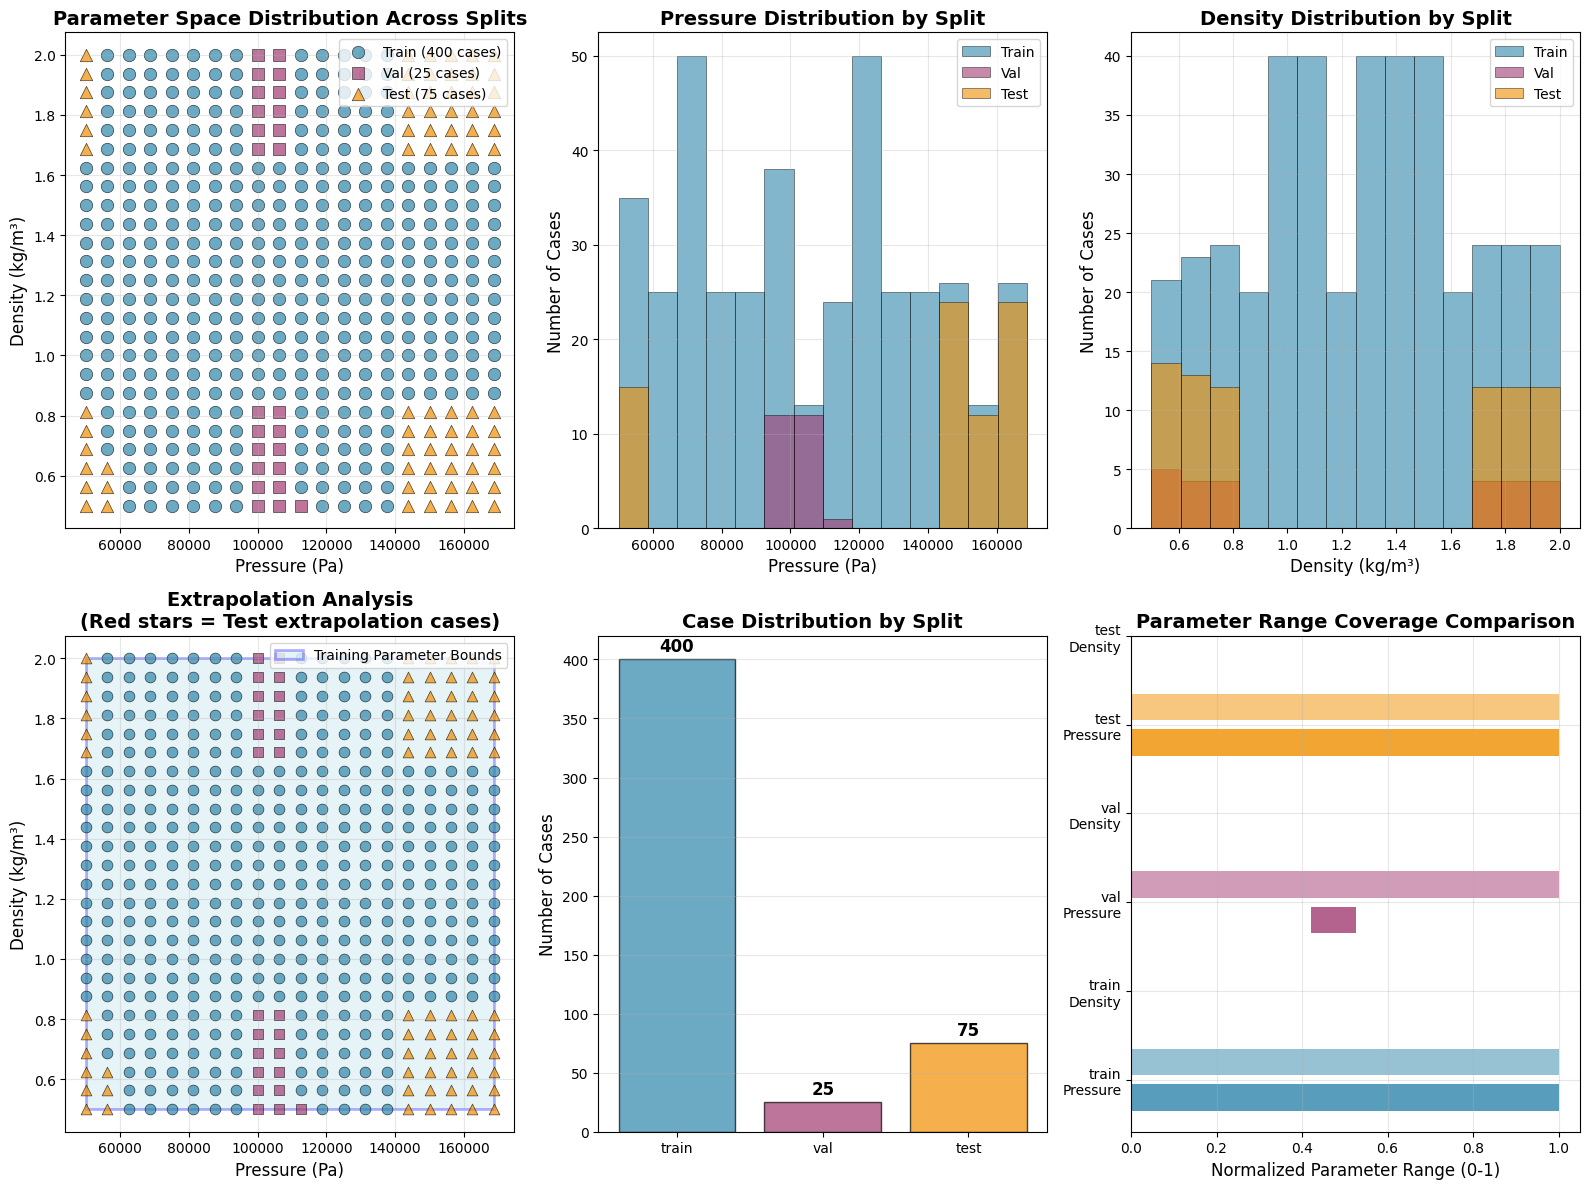

Analysis data saved to: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/parameter_split_analysis.json

Visualization complete!


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from collections import defaultdict
import json

class ParameterSplitVisualizer:
    """
    Visualize parameter space distribution from existing train/test/val case directories.
    """
    
    def __init__(self, base_dir):
        self.base_dir = Path(base_dir)
        self.splits = ['train', 'val', 'test']
        self.colors = {'train': '#2E86AB', 'val': '#A23B72', 'test': '#F18F01'}
        self.markers = {'train': 'o', 'val': 's', 'test': '^'}
        
    def extract_parameters_from_filename(self, filename):
        """Extract pressure and density from case filename."""
        # Pattern: p_L_125000_rho_L_1.5_split_with_pos.pt
        pressure_match = re.search(r'p_L_(\d+)', filename)
        density_match = re.search(r'rho_L_([\d.]+)', filename)
        
        pressure = float(pressure_match.group(1)) if pressure_match else None
        density = float(density_match.group(1)) if density_match else None
        
        return pressure, density
    
    def load_split_parameters(self):
        """Load parameter information from all split directories."""
        split_data = {}
        
        for split in self.splits:
            split_dir = self.base_dir / f"{split}_cases"
            split_data[split] = {'pressures': [], 'densities': [], 'case_names': []}
            
            if not split_dir.exists():
                print(f"Warning: {split_dir} not found, skipping {split} split")
                continue
            
            # Get all .pt files in the split directory
            case_files = list(split_dir.glob("*.pt"))
            print(f"Found {len(case_files)} cases in {split} split")
            
            for case_file in case_files:
                pressure, density = self.extract_parameters_from_filename(case_file.name)
                if pressure is not None and density is not None:
                    split_data[split]['pressures'].append(pressure)
                    split_data[split]['densities'].append(density)
                    # Extract case name (remove split suffix)
                    case_name = case_file.name.replace(f'_{split}_with_pos.pt', '')
                    split_data[split]['case_names'].append(case_name)
        
        return split_data
    
    def analyze_parameter_space(self, split_data):
        """Analyze the parameter space coverage."""
        all_pressures = []
        all_densities = []
        
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
            all_densities.extend(split_data[split]['densities'])
        
        analysis = {
            'pressure_range': [min(all_pressures), max(all_pressures)] if all_pressures else [0, 0],
            'density_range': [min(all_densities), max(all_densities)] if all_densities else [0, 0],
            'unique_pressures': sorted(set(all_pressures)),
            'unique_densities': sorted(set(all_densities)),
            'total_cases': len(all_pressures)
        }
        
        return analysis
    
    def create_visualizations(self, split_data, output_dir=None):
        """Create comprehensive parameter space visualizations."""
        if output_dir is None:
            output_dir = self.base_dir
        
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Parameter space scatter plot
        ax1 = plt.subplot(2, 3, 1)
        for split in self.splits:
            data = split_data[split]
            if data['pressures'] and data['densities']:
                ax1.scatter(data['pressures'], data['densities'], 
                           c=self.colors[split], marker=self.markers[split], 
                           alpha=0.7, s=80, label=f'{split.title()} ({len(data["pressures"])} cases)',
                           edgecolors='black', linewidth=0.5)
        
        ax1.set_xlabel('Pressure (Pa)', fontsize=12)
        ax1.set_ylabel('Density (kg/m³)', fontsize=12)
        ax1.set_title('Parameter Space Distribution Across Splits', fontsize=14, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # 2. Pressure distribution histogram
        ax2 = plt.subplot(2, 3, 2)
        all_pressures = []
        for split in self.splits:
            all_pressures.extend(split_data[split]['pressures'])
        
        if all_pressures:
            pressure_bins = np.linspace(min(all_pressures), max(all_pressures), 15)
            for split in self.splits:
                data = split_data[split]
                if data['pressures']:
                    ax2.hist(data['pressures'], bins=pressure_bins, alpha=0.6, 
                            color=self.colors[split], label=f'{split.title()}',
                            edgecolor='black', linewidth=0.5)
        
        ax2.set_xlabel('Pressure (Pa)', fontsize=12)
        ax2.set_ylabel('Number of Cases', fontsize=12)
        ax2.set_title('Pressure Distribution by Split', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # 3. Density distribution histogram
        ax3 = plt.subplot(2, 3, 3)
        all_densities = []
        for split in self.splits:
            all_densities.extend(split_data[split]['densities'])
        
        if all_densities:
            density_bins = np.linspace(min(all_densities), max(all_densities), 15)
            for split in self.splits:
                data = split_data[split]
                if data['densities']:
                    ax3.hist(data['densities'], bins=density_bins, alpha=0.6, 
                            color=self.colors[split], label=f'{split.title()}',
                            edgecolor='black', linewidth=0.5)
        
        ax3.set_xlabel('Density (kg/m³)', fontsize=12)
        ax3.set_ylabel('Number of Cases', fontsize=12)
        ax3.set_title('Density Distribution by Split', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # 4. Training bounds analysis
        ax4 = plt.subplot(2, 3, 4)
        
        # Get training bounds
        train_data = split_data['train']
        if train_data['pressures'] and train_data['densities']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            
            # Draw training bounds rectangle
            from matplotlib.patches import Rectangle
            rect = Rectangle((train_p_min, train_d_min), 
                           train_p_max - train_p_min, 
                           train_d_max - train_d_min,
                           linewidth=2, edgecolor='blue', 
                           facecolor='lightblue', alpha=0.3,
                           label='Training Parameter Bounds')
            ax4.add_patch(rect)
            
            # Plot all points with extrapolation highlighting
            for split in self.splits:
                data = split_data[split]
                for p, d in zip(data['pressures'], data['densities']):
                    is_extrapolation = (p < train_p_min or p > train_p_max or 
                                      d < train_d_min or d > train_d_max)
                    
                    if split == 'test' and is_extrapolation:
                        # Highlight test extrapolation cases
                        ax4.scatter(p, d, c='red', marker='*', s=150, 
                                  edgecolors='black', linewidth=1, 
                                  label='Test Extrapolation' if p == data['pressures'][0] else "")
                    else:
                        ax4.scatter(p, d, c=self.colors[split], 
                                  marker=self.markers[split], alpha=0.7, s=60,
                                  edgecolors='black', linewidth=0.5)
        
        ax4.set_xlabel('Pressure (Pa)', fontsize=12)
        ax4.set_ylabel('Density (kg/m³)', fontsize=12)
        ax4.set_title('Extrapolation Analysis\n(Red stars = Test extrapolation cases)', fontsize=14, fontweight='bold')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        # 5. Case count comparison
        ax5 = plt.subplot(2, 3, 5)
        
        split_names = [split for split in self.splits if split_data[split]['pressures']]
        case_counts = [len(split_data[split]['pressures']) for split in split_names]
        
        bars = ax5.bar(split_names, case_counts, 
                      color=[self.colors[split] for split in split_names],
                      alpha=0.7, edgecolor='black', linewidth=1)
        
        # Add value labels on bars
        for bar, count in zip(bars, case_counts):
            ax5.annotate(f'{count}',
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12, fontweight='bold')
        
        ax5.set_ylabel('Number of Cases', fontsize=12)
        ax5.set_title('Case Distribution by Split', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        
        # 6. Parameter range coverage
        ax6 = plt.subplot(2, 3, 6)
        
        # Create range comparison
        y_positions = np.arange(len(self.splits))
        
        for i, split in enumerate(self.splits):
            data = split_data[split]
            if data['pressures'] and data['densities']:
                p_min, p_max = min(data['pressures']), max(data['pressures'])
                d_min, d_max = min(data['densities']), max(data['densities'])
                
                # Normalize to 0-1 for visualization
                all_p = []
                all_d = []
                for s in self.splits:
                    all_p.extend(split_data[s]['pressures'])
                    all_d.extend(split_data[s]['densities'])
                
                if all_p and all_d:
                    global_p_min, global_p_max = min(all_p), max(all_p)
                    global_d_min, global_d_max = min(all_d), max(all_d)
                    
                    p_norm_min = (p_min - global_p_min) / (global_p_max - global_p_min) if global_p_max > global_p_min else 0
                    p_norm_max = (p_max - global_p_min) / (global_p_max - global_p_min) if global_p_max > global_p_min else 0
                    
                    ax6.barh(i*2, p_norm_max - p_norm_min, left=p_norm_min, height=0.3,
                            color=self.colors[split], alpha=0.8, 
                            label=f'{split} Pressure' if i == 0 else "")
                    
                    d_norm_min = (d_min - global_d_min) / (global_d_max - global_d_min) if global_d_max > global_d_min else 0
                    d_norm_max = (d_max - global_d_min) / (global_d_max - global_d_min) if global_d_max > global_d_min else 0
                    
                    ax6.barh(i*2+0.4, d_norm_max - d_norm_min, left=d_norm_min, height=0.3,
                            color=self.colors[split], alpha=0.5,
                            label=f'{split} Density' if i == 0 else "")
        
        ax6.set_yticks(np.arange(len(self.splits)*2) + 0.2)
        ax6.set_yticklabels([f'{split}\nPressure' if i%2==0 else f'{split}\nDensity' 
                            for split in self.splits for i in range(2)])
        ax6.set_xlabel('Normalized Parameter Range (0-1)', fontsize=12)
        ax6.set_title('Parameter Range Coverage Comparison', fontsize=14, fontweight='bold')
        ax6.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save the visualization
        output_path = Path(output_dir)
        viz_file = output_path / 'parameter_space_analysis.png'
        plt.savefig(viz_file, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to: {viz_file}")
        
        # Also save as PDF
        viz_file_pdf = output_path / 'parameter_space_analysis.pdf'
        plt.savefig(viz_file_pdf, bbox_inches='tight')
        print(f"PDF saved to: {viz_file_pdf}")
        
        plt.show()
        
        return fig
    
    def print_parameter_analysis(self, split_data, analysis):
        """Print detailed parameter analysis to console."""
        print("\n" + "="*80)
        print("PARAMETER SPACE ANALYSIS")
        print("="*80)
        
        print(f"\nOverall Parameter Space:")
        print(f"  Pressure range: {analysis['pressure_range'][0]:.0f} - {analysis['pressure_range'][1]:.0f} Pa")
        print(f"  Density range:  {analysis['density_range'][0]:.3f} - {analysis['density_range'][1]:.3f} kg/m³")
        print(f"  Total cases: {analysis['total_cases']}")
        print(f"  Unique pressures: {len(analysis['unique_pressures'])}")
        print(f"  Unique densities: {len(analysis['unique_densities'])}")
        
        print(f"\nSplit Distribution:")
        for split in self.splits:
            data = split_data[split]
            if data['pressures']:
                p_range = f"{min(data['pressures']):.0f} - {max(data['pressures']):.0f}"
                d_range = f"{min(data['densities']):.3f} - {max(data['densities']):.3f}"
                print(f"  {split.upper()}: {len(data['pressures'])} cases")
                print(f"    Pressure: {p_range} Pa")
                print(f"    Density:  {d_range} kg/m³")
            else:
                print(f"  {split.upper()}: No cases found")
        
        # Extrapolation analysis
        train_data = split_data['train']
        test_data = split_data['test']
        
        if train_data['pressures'] and test_data['pressures']:
            train_p_min, train_p_max = min(train_data['pressures']), max(train_data['pressures'])
            train_d_min, train_d_max = min(train_data['densities']), max(train_data['densities'])
            
            test_extrapolation_cases = 0
            for p, d in zip(test_data['pressures'], test_data['densities']):
                if p < train_p_min or p > train_p_max or d < train_d_min or d > train_d_max:
                    test_extrapolation_cases += 1
            
            print(f"\nExtrapolation Analysis:")
            print(f"  Training bounds:")
            print(f"    Pressure: [{train_p_min:.0f}, {train_p_max:.0f}] Pa")
            print(f"    Density:  [{train_d_min:.3f}, {train_d_max:.3f}] kg/m³")
            print(f"  Test extrapolation cases: {test_extrapolation_cases}/{len(test_data['pressures'])} ({test_extrapolation_cases/len(test_data['pressures'])*100:.1f}%)")
    
    def save_analysis_json(self, split_data, analysis, output_dir=None):
        """Save analysis results as JSON."""
        if output_dir is None:
            output_dir = self.base_dir
        
        output_data = {
            'parameter_analysis': analysis,
            'split_data': split_data,
            'timestamp': str(np.datetime64('now'))
        }
        
        json_file = Path(output_dir) / 'parameter_split_analysis.json'
        with open(json_file, 'w') as f:
            json.dump(output_data, f, indent=2)
        
        print(f"Analysis data saved to: {json_file}")


def main():
    """Main execution function."""
    BASE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt"
    
    print("Visualizing Parameter Space Distribution from Train/Test/Val Splits")
    print("="*80)
    print(f"Base directory: {BASE_DIR}")
    
    # Initialize visualizer
    visualizer = ParameterSplitVisualizer(BASE_DIR)
    
    # Load parameter data from split directories
    split_data = visualizer.load_split_parameters()
    
    # Analyze parameter space
    analysis = visualizer.analyze_parameter_space(split_data)
    
    # Print analysis
    visualizer.print_parameter_analysis(split_data, analysis)
    
    # Create visualizations
    visualizer.create_visualizations(split_data)
    
    # Save analysis as JSON
    visualizer.save_analysis_json(split_data, analysis)
    
    print("\nVisualization complete!")


if __name__ == "__main__":
    main()

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
import json
from datetime import datetime
import os
from collections import defaultdict

class CorrectedEnhancedShockTubeBatchProcessor:
    """
    Corrected enhanced version that includes:
    1. Global parameters (not node-replicated)
    2. Variable statistics computation
    3. Full train/test/val split pipeline
    4. Delta_t extraction from HDF5 files
    """
    
    def __init__(self, base_data_dir, include_parameters_as_features=True):
        self.base_data_dir = Path(base_data_dir)
        self.grid_size = 64
        self.width = 64
        self.height = 64
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'total_energy']
        
        # Parameter inclusion settings
        self.include_parameters_as_features = include_parameters_as_features
        self.parameter_names = ['pressure', 'density_param', 'delta_t']
        
        # For tracking processed cases
        self.case_info = {}
        self.all_variable_stats = {}
        self.parameter_stats = {}
        
    def extract_delta_t_from_files(self, files):
        """
        Extract delta_t from HDF5 files. Tries multiple approaches:
        1. Look for explicit delta_t/dt in file attributes/datasets
        2. Calculate from consecutive time values (may be output frequency, not timestep)
        """
        time_values = []
        explicit_delta_t = None
        
        # First, try to find explicit delta_t values
        for file_path in files:
            try:
                with h5py.File(file_path, 'r') as f:
                    # Try common locations for explicit delta_t
                    dt_locations = ['dt', 'delta_t', 'timestep', 'time_step', 'deltat']
                    
                    # Check level_0 group first (most likely location based on your test)
                    if explicit_delta_t is None and 'level_0' in f:
                        level_group = f['level_0']
                        for dt_name in dt_locations:
                            if dt_name in level_group.attrs:
                                explicit_delta_t = float(level_group.attrs[dt_name])
                                print(f"    Found explicit delta_t in level_0 attrs: {explicit_delta_t:.6e}")
                                break
                    
                    # If we found explicit delta_t, we can stop looking
                    if explicit_delta_t is not None:
                        break
                        
            except Exception as e:
                print(f"    Warning: Could not read delta_t from {file_path}: {e}")
                continue
        
        # If no explicit delta_t found, try extracting from time progression
        if explicit_delta_t is None:
            print("    No explicit delta_t found, analyzing time progression...")
            
            for file_path in files:
                try:
                    with h5py.File(file_path, 'r') as f:
                        # Try common locations for time data
                        time_value = None
                        possible_locations = ['time', 'TIME', 'current_time', 'simulation_time', 'Time']
                        
                        # Check root attributes
                        for attr_name in possible_locations:
                            if attr_name in f.attrs:
                                time_value = float(f.attrs[attr_name])
                                break
                        
                        # Check level_0 group
                        if time_value is None and 'level_0' in f:
                            level_group = f['level_0']
                            for attr_name in possible_locations:
                                if attr_name in level_group.attrs:
                                    time_value = float(level_group.attrs[attr_name])
                                    break
                        
                        if time_value is not None:
                            time_values.append(time_value)
                            
                except Exception as e:
                    print(f"    Warning: Could not extract time from {file_path}: {e}")
                    continue
        
        # Return results
        if explicit_delta_t is not None:
            # We found the actual simulation timestep
            return explicit_delta_t, 0.0, time_values
        elif len(time_values) > 1:
            # Calculate from time progression (WARNING: this may be output frequency)
            time_diffs = np.diff(time_values)
            mean_dt = float(np.mean(time_diffs))
            std_dt = float(np.std(time_diffs))
            
            print(f"    WARNING: Using time differences as delta_t proxy: {mean_dt:.6e} s")
            return mean_dt, std_dt, time_values
        else:
            print("    WARNING: Could not determine delta_t from files")
            return None, None, time_values

    def discover_cases(self):
        """Discover all available shock tube cases in the hierarchical directory structure."""
        print(f"🔍 Discovering cases in: {self.base_data_dir}")
        
        if not self.base_data_dir.exists():
            print(f"❌ Directory {self.base_data_dir} does not exist!")
            return []
        
        case_dirs = []
        
        pressure_dirs = sorted([d for d in self.base_data_dir.iterdir() 
                               if d.is_dir() and d.name.startswith('p_L_')])
        
        print(f"  Found {len(pressure_dirs)} pressure directories")
        
        for p_dir in pressure_dirs:
            pressure_val = p_dir.name
            density_dirs = sorted([d for d in p_dir.iterdir() 
                                 if d.is_dir() and d.name.startswith('rho_L_')])
            
            print(f"    {pressure_val}: {len(density_dirs)} density directories")
            
            for rho_dir in density_dirs:
                density_val = rho_dir.name
                plot_dir = rho_dir / 'plot'
                if plot_dir.exists() and plot_dir.is_dir():
                    hdf5_files = list(plot_dir.glob('*.plot.*.2d.hdf5'))
                    if hdf5_files:
                        case_name = f"{pressure_val}_{density_val}"
                        case_dirs.append((plot_dir, case_name, pressure_val, density_val))
                        print(f"      ✅ {case_name}: {len(hdf5_files)} HDF5 files")
                    else:
                        print(f"      ❌ {pressure_val}_{density_val}: No HDF5 files in plot directory")
                else:
                    print(f"      ❌ {pressure_val}_{density_val}: No plot directory found")
        
        if not case_dirs:
            print("❌ No valid cases with HDF5 files found!")
        else:
            print(f"✅ Total valid cases discovered: {len(case_dirs)}")
            
        return case_dirs

    def get_timestep_files(self, case_dir, pattern="*.plot.*.2d.hdf5"):
        """Get a sorted list of timestep files for a specific case."""
        files = [f for f in case_dir.glob(pattern) if '.map.' not in f.name]
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        return sorted(files, key=extract_timestep)

    def parse_case_parameters(self, case_name, pressure_val, density_val):
        """Extract numerical parameter values from directory names."""
        pressure_match = re.search(r'p_L_(\d+)', pressure_val)
        pressure_numeric = float(pressure_match.group(1)) if pressure_match else None
        
        density_match = re.search(r'rho_L_([\d.]+)', density_val)
        density_numeric = float(density_match.group(1)) if density_match else None
        
        return {
            'pressure_str': pressure_val,
            'density_str': density_val,
            'pressure_numeric': pressure_numeric,
            'density_numeric': density_numeric,
            'case_name': case_name
        }

    def read_chombo_data(self, filename):
        """Read and reconstruct 2D grid data from Chombo HDF5 format."""
        with h5py.File(filename, 'r') as f:
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            n_vars = len(offsets) - 1

            if len(self.var_names) != n_vars:
                print(f"Warning: Expected {len(self.var_names)} variables but file contains {n_vars}.")
                var_names = [f'var_{i}' for i in range(n_vars)]
            else:
                var_names = self.var_names
            
            grids = {name: np.zeros((self.grid_size, self.grid_size)) for name in var_names}
            
            data_idx = 0
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                box_data = data_flat[data_idx:data_idx + box_size * n_vars]
                data_idx += box_size * n_vars
                for var_idx, name in enumerate(var_names):
                    var_data = box_data[var_idx * box_size:(var_idx + 1) * box_size]
                    var_data_2d = var_data.reshape((nj, ni))
                    grids[name][box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = var_data_2d
            
            return grids, var_names, boxes

    def _create_graph_connectivity(self):
        """Helper to create the edge_index for a 2D grid graph."""
        num_nodes = self.width * self.height
        nodes = np.arange(num_nodes).reshape(self.height, self.width)
        edges = []

        for i in range(self.height):
            for j in range(self.width - 1):
                edges.append([nodes[i, j], nodes[i, j+1]])
                edges.append([nodes[i, j+1], nodes[i, j]])

        for i in range(self.height - 1):
            for j in range(self.width):
                edges.append([nodes[i, j], nodes[i+1, j]])
                edges.append([nodes[i+1, j], nodes[i, j]])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        return edge_index

    def create_global_parameters(self, pressure_numeric, density_numeric, delta_t):
        """Create global parameter tensor stored once per graph."""
        if not self.include_parameters_as_features:
            return None
        
        # Create single parameter vector for the entire graph
        global_params = torch.tensor([
            pressure_numeric if pressure_numeric is not None else 0.0,
            density_numeric if density_numeric is not None else 0.0,
            delta_t if delta_t is not None else 0.0
        ], dtype=torch.float)
        
        return global_params

    def analyze_variable_ranges_single_case(self, case_dir, case_name):
        """Analyze variable ranges for a single case."""
        files = self.get_timestep_files(case_dir)
        if not files:
            print(f"    Warning: No files found for case {case_name}")
            return None
        
        print(f"  Analyzing variable ranges for {case_name}...")
        
        case_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                           'all_values': []} for var in self.var_names}
        
        valid_files_count = 0
        
        for file in files:
            try:
                grids, _, _ = self.read_chombo_data(file)
                valid_files_count += 1
                
                for var in self.var_names:
                    if var in grids:
                        data = grids[var]
                        # Filter out invalid values
                        valid_data = data[np.isfinite(data)]
                        if len(valid_data) > 0:
                            case_stats[var]['min'] = min(case_stats[var]['min'], valid_data.min())
                            case_stats[var]['max'] = max(case_stats[var]['max'], valid_data.max())
                            case_stats[var]['all_values'].extend(valid_data.flatten())
                        
            except Exception as e:
                print(f"    Warning: Could not read {file}: {e}")
                continue
        
        if valid_files_count == 0:
            print(f"    Warning: No valid files could be read for case {case_name}")
            return None
        
        # Compute additional statistics
        final_stats = {}
        for var in self.var_names:
            if case_stats[var]['all_values'] and case_stats[var]['min'] != float('inf'):
                values = np.array(case_stats[var]['all_values'])
                final_stats[var] = {
                    'min': float(case_stats[var]['min']),
                    'max': float(case_stats[var]['max']),
                    'mean': float(values.mean()),
                    'std': float(values.std()),
                    'median': float(np.median(values)),
                    'q25': float(np.percentile(values, 25)),
                    'q75': float(np.percentile(values, 75))
                }
            else:
                print(f"    Warning: No valid data found for variable {var} in case {case_name}")
        
        return final_stats if final_stats else None

    def process_single_case(self, case_dir, case_name, pressure_val, density_val, output_path):
        """Process a single shock tube case into PyG format with global parameters."""
        print(f"\n📁 Processing case: {case_name}")
        print(f"    Directory: {case_dir}")
        
        files = self.get_timestep_files(case_dir)
        if len(files) < 2:
            print(f"❌ Case {case_name} has insufficient files ({len(files)}). Skipping.")
            return None

        print(f"  Found {len(files)} timestep files")
        
        # Parse case parameters
        case_params = self.parse_case_parameters(case_name, pressure_val, density_val)
        pressure_numeric = case_params['pressure_numeric']
        density_numeric = case_params['density_numeric']
        
        # Extract delta_t from the files
        mean_dt, std_dt, time_values = self.extract_delta_t_from_files(files)
        
        if mean_dt is None:
            print(f"  Warning: Could not extract delta_t for case {case_name}")
            mean_dt = 1e-6  # Default fallback value
        
        print(f"  Extracted delta_t: {mean_dt:.6e} s (std: {std_dt:.6e} s)" if std_dt else f"  Extracted delta_t: {mean_dt:.6e} s")
        
        # Store parameter statistics
        if case_name not in self.parameter_stats:
            self.parameter_stats[case_name] = {
                'pressure': pressure_numeric,
                'density_param': density_numeric,
                'delta_t': mean_dt,
                'delta_t_std': std_dt
            }
        
        # Analyze variable ranges for this case
        case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name)
        
        pyg_data_list = []
        edge_index = self._create_graph_connectivity()
        
        # Create normalized position grid
        x_coords = torch.arange(self.width, dtype=torch.float) / (self.width - 1)
        y_coords = torch.arange(self.height, dtype=torch.float) / (self.height - 1)
        pos_grid = torch.stack(torch.meshgrid(x_coords, y_coords, indexing='xy'), dim=-1)
        pos = pos_grid.reshape(-1, 2)  # Shape: [N, 2]

        # Create global parameter features (stored once per graph)
        global_params = self.create_global_parameters(pressure_numeric, density_numeric, mean_dt)

        # Process consecutive timestep pairs
        valid_pairs = 0
        for i in range(len(files) - 1):
            current_file = files[i]
            next_file = files[i+1]
            
            try:
                # Read data for current and next timestep
                grids_current, _, _ = self.read_chombo_data(current_file)
                grids_next, _, _ = self.read_chombo_data(next_file)

                # Stack physics features: (H, W, C) -> (N, C)
                physics_features = np.stack([grids_current[name] for name in self.var_names], axis=-1)
                physics_features = physics_features.reshape(-1, len(self.var_names))  # [N, 4]
                
                # Stack target features
                target_features = np.stack([grids_next[name] for name in self.var_names], axis=-1)
                target_features = target_features.reshape(-1, len(self.var_names))  # [N, 4]
                
                # Combine node features: [x_pos, y_pos, density, x_momentum, y_momentum, total_energy]
                # Parameters are stored separately in global_params
                combined_features = np.concatenate([pos.numpy(), physics_features], axis=1)  # [N, 6]
                
                x = torch.tensor(combined_features, dtype=torch.float)
                y = torch.tensor(target_features, dtype=torch.float)  # [N, 4]
                
                # Create PyG Data object with global parameters
                data_object = Data(
                    x=x, 
                    edge_index=edge_index, 
                    pos=pos, 
                    y=y,
                    # Global parameters stored once per graph
                    global_params=global_params if self.include_parameters_as_features else None,
                    # Individual parameter access for convenience
                    case_name=case_name,
                    pressure_str=pressure_val,
                    density_str=density_val,
                    pressure_numeric=pressure_numeric,
                    density_numeric=density_numeric,
                    delta_t=mean_dt,
                    delta_t_std=std_dt,
                    timestep_current=i,
                    timestep_next=i+1,
                    # Store actual time values if available
                    time_current=time_values[i] if i < len(time_values) else None,
                    time_next=time_values[i+1] if i+1 < len(time_values) else None
                )
                
                pyg_data_list.append(data_object)
                valid_pairs += 1
                
            except Exception as e:
                print(f"    ⚠️  Error processing timestep {i}->{i+1}: {e}")
                continue
        
        print(f"  ✅ Successfully processed {valid_pairs} timestep pairs")
        
        if pyg_data_list:
            # Save this case separately
            case_filename = f"{case_name}_enhanced_with_params.pt"
            case_filepath = output_path / "individual_cases" / case_filename
            case_filepath.parent.mkdir(exist_ok=True)
            torch.save(pyg_data_list, case_filepath)
            print(f"  💾 Saved individual case: {case_filepath}")
        
        # Store case information including variable statistics
        self.case_info[case_name] = {
            'total_files': len(files),
            'processed_pairs': len(pyg_data_list),
            'directory': str(case_dir),
            'parameters': case_params,
            'variable_statistics': case_var_stats,
            'delta_t': mean_dt,
            'delta_t_std': std_dt,
            'time_values': time_values,
            'feature_dimensions': {
                'node_features': 2 + len(self.var_names),  # [x_pos, y_pos, physics_vars]
                'global_features': len(self.parameter_names) if self.include_parameters_as_features else 0,
                'position_features': 2,
                'physics_features': len(self.var_names),
                'parameter_storage': 'global' if self.include_parameters_as_features else 'none'
            },
            'saved_file': str(case_filepath) if pyg_data_list else None
        }
        
        return pyg_data_list

    def analyze_global_variable_ranges(self, case_info_list):
        """Analyze variable ranges across all cases before processing."""
        print("\n" + "="*80)
        print("📊 ANALYZING VARIABLE RANGES ACROSS ALL CASES")
        print("="*80)
        
        global_stats = {var: {'min': float('inf'), 'max': float('-inf'), 
                             'case_mins': [], 'case_maxs': [], 'case_means': []} 
                       for var in self.var_names}
        
        case_stats_summary = {}
        processed_cases = 0
        
        for case_dir, case_name, pressure_val, density_val in case_info_list:
            case_var_stats = self.analyze_variable_ranges_single_case(case_dir, case_name)
            
            if case_var_stats is not None and case_var_stats:
                case_stats_summary[case_name] = case_var_stats
                processed_cases += 1
                
                for var in self.var_names:
                    if var in case_var_stats and 'mean' in case_var_stats[var]:
                        stats = case_var_stats[var]
                        global_stats[var]['min'] = min(global_stats[var]['min'], stats['min'])
                        global_stats[var]['max'] = max(global_stats[var]['max'], stats['max'])
                        global_stats[var]['case_mins'].append(stats['min'])
                        global_stats[var]['case_maxs'].append(stats['max'])
                        global_stats[var]['case_means'].append(stats['mean'])
        
        # Compute global statistics
        for var in self.var_names:
            if global_stats[var]['case_means']:
                global_stats[var]['global_mean_of_means'] = np.mean(global_stats[var]['case_means'])
                global_stats[var]['std_of_means'] = np.std(global_stats[var]['case_means'])
                global_stats[var]['range'] = global_stats[var]['max'] - global_stats[var]['min']
        
        print(f"\n🌐 GLOBAL VARIABLE STATISTICS SUMMARY (from {processed_cases} cases):")
        print("="*60)
        for var in self.var_names:
            stats = global_stats[var]
            if stats['case_means']:
                print(f"\n{var.upper()}:")
                print(f"  Global Range: [{stats['min']:.6e}, {stats['max']:.6e}]")
                print(f"  Range Span: {stats['range']:.6e}")
                print(f"  Mean across cases: {stats['global_mean_of_means']:.6e} ± {stats['std_of_means']:.6e}")
        
        self.all_variable_stats = {
            'global_statistics': global_stats,
            'case_statistics': case_stats_summary
        }
        
        return global_stats, case_stats_summary

    def analyze_parameter_statistics(self):
        """Analyze parameter statistics across all cases for normalization."""
        if not self.parameter_stats:
            return None
        
        print(f"\nAnalyzing parameter statistics across {len(self.parameter_stats)} cases...")
        
        pressures = [stats['pressure'] for stats in self.parameter_stats.values() if stats['pressure']]
        densities = [stats['density_param'] for stats in self.parameter_stats.values() if stats['density_param']]
        delta_ts = [stats['delta_t'] for stats in self.parameter_stats.values() if stats['delta_t']]
        
        param_analysis = {
            'pressure': {
                'min': min(pressures) if pressures else None,
                'max': max(pressures) if pressures else None,
                'mean': np.mean(pressures) if pressures else None,
                'std': np.std(pressures) if pressures else None
            },
            'density_param': {
                'min': min(densities) if densities else None,
                'max': max(densities) if densities else None,
                'mean': np.mean(densities) if densities else None,
                'std': np.std(densities) if densities else None
            },
            'delta_t': {
                'min': min(delta_ts) if delta_ts else None,
                'max': max(delta_ts) if delta_ts else None,
                'mean': np.mean(delta_ts) if delta_ts else None,
                'std': np.std(delta_ts) if delta_ts else None
            }
        }
        
        print("Parameter Statistics Summary:")
        print("="*50)
        for param_name, stats in param_analysis.items():
            if stats['min'] is not None:
                print(f"{param_name.upper()}:")
                print(f"  Range: [{stats['min']:.6e}, {stats['max']:.6e}]")
                print(f"  Mean ± Std: {stats['mean']:.6e} ± {stats['std']:.6e}")
                print()
        
        return param_analysis

    def process_all_cases(self, output_dir="processed_datasets_enhanced"):
        """Process all discovered cases and save individually, then analyze before splitting."""
        print("\n" + "="*80)
        print("🚀 BATCH PROCESSING ALL SHOCK TUBE CASES WITH GLOBAL PARAMETERS")
        print("="*80)
        
        case_info_list = self.discover_cases()
        if not case_info_list:
            print("❌ No cases found to process!")
            return None
        
        # First, analyze variable ranges across all cases
        global_stats, case_stats = self.analyze_global_variable_ranges(case_info_list)
        
        if global_stats is None:
            print("❌ Variable range analysis failed!")
            return None
        
        # Create output directory
        output_path = Path(output_dir)
        output_path.mkdir(exist_ok=True)
        (output_path / "individual_cases").mkdir(exist_ok=True)
        
        all_data = []
        case_sample_counts = {}
        parameter_ranges = {'pressure': [], 'density': [], 'delta_t': []}
        
        print(f"\n🔄 PROCESSING INDIVIDUAL CASES:")
        print("="*60)
        
        # Process each case
        for case_dir, case_name, pressure_val, density_val in case_info_list:
            case_data = self.process_single_case(case_dir, case_name, pressure_val, density_val, output_path)
            
            if case_data:
                all_data.extend(case_data)
                case_sample_counts[case_name] = len(case_data)
                
                # Track parameter ranges
                case_params = self.parse_case_parameters(case_name, pressure_val, density_val)
                if case_params['pressure_numeric'] is not None:
                    parameter_ranges['pressure'].append(case_params['pressure_numeric'])
                if case_params['density_numeric'] is not None:
                    parameter_ranges['density'].append(case_params['density_numeric'])
                
                # Get delta_t from parameter stats
                if case_name in self.parameter_stats and self.parameter_stats[case_name]['delta_t']:
                    parameter_ranges['delta_t'].append(self.parameter_stats[case_name]['delta_t'])
            else:
                print(f"❌ No data processed for case: {case_name}")
        
        if not all_data:
            print("❌ No data was successfully processed!")
            return None
        
        # Analyze parameter statistics
        param_analysis = self.analyze_parameter_statistics()
        
        # Calculate parameter statistics
        pressure_stats = {
            'min': min(parameter_ranges['pressure']) if parameter_ranges['pressure'] else None,
            'max': max(parameter_ranges['pressure']) if parameter_ranges['pressure'] else None,
            'unique_values': sorted(list(set(parameter_ranges['pressure']))) if parameter_ranges['pressure'] else []
        }
        density_stats = {
            'min': min(parameter_ranges['density']) if parameter_ranges['density'] else None,
            'max': max(parameter_ranges['density']) if parameter_ranges['density'] else None,
            'unique_values': sorted(list(set(parameter_ranges['density']))) if parameter_ranges['density'] else []
        }
        
        print(f"\n📊 PROCESSING SUMMARY:")
        print("="*60)
        print(f"  Total cases processed: {len(case_sample_counts)}")
        print(f"  Total samples: {len(all_data)}")
        print(f"  Node feature dimensions: {all_data[0].x.shape[1]} per node")
        
        if self.include_parameters_as_features:
            print(f"  Global parameter dimensions: {all_data[0].global_params.shape[0] if all_data[0].global_params is not None else 0}")
            print(f"    - Node features: position (2) + physics ({len(self.var_names)})")
            print(f"    - Global features: parameters ({len(self.parameter_names)}) - pressure, density_param, delta_t")
            print(f"  Parameter storage: Global (efficient)")
        else:
            print(f"  Parameter inclusion: DISABLED")
        
        # Save comprehensive metadata
        metadata = {
            'timestamp': datetime.now().isoformat(),
            'total_samples': len(all_data),
            'total_cases': len(case_sample_counts),
            'include_parameters_as_features': self.include_parameters_as_features,
            'parameter_storage_method': 'global_graph_attributes' if self.include_parameters_as_features else None,
            'parameter_names': self.parameter_names if self.include_parameters_as_features else [],
            'case_info': self.case_info,
            'case_sample_counts': case_sample_counts,
            'parameter_statistics': param_analysis,
            'variable_statistics': self.all_variable_stats,
            'parameter_summary': {
                'pressure': pressure_stats,
                'density': density_stats
            },
            'feature_layout': self._get_feature_layout_description(),
            'target_layout': '[density, x_momentum, y_momentum, total_energy]',
            'grid_size': f'{self.grid_size}x{self.grid_size}',
            'domain_size': '0.5x0.5 meters',
            'pressure_ratio': '10:1 (left:right)',
            'density_ratio': '8:1 (left:right)',
            'physics_model': 'Compressible Euler equations',
            'directory_structure': 'cases/p_L_*/rho_L_*/plot/*.hdf5',
            'normalization_applied': 'raw values (no scaling)' if self.include_parameters_as_features else None
        }
        
        with open(output_path / 'enhanced_dataset_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
        
        # Also save just the variable statistics for easy access
        with open(output_path / 'variable_statistics.json', 'w') as f:
            json.dump(self.all_variable_stats, f, indent=2)
        
        return all_data, output_path

    def create_train_test_val_split(self, all_data, output_path, 
                                  train_ratio=0.7, val_ratio=0.15, test_ratio=0.15,
                                  random_state=42, split_by_parameter_ranges=True):
        """
        Create train/test/validation splits by parameter ranges for extrapolation/interpolation testing.
        This ensures proper physics generalization testing with unseen parameter combinations.
        """
        print(f"\n📊 CREATING TRAIN/TEST/VAL SPLIT BY PARAMETER RANGES")
        print(f"  Ratios - Train: {train_ratio}, Val: {val_ratio}, Test: {test_ratio}")
        
        if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
            print(f"❌ Split ratios don't sum to 1.0!")
            return None
        
        # Group data by case name and extract parameter information
        case_groups = {}
        case_params = {}
        for data in all_data:
            case_name = data.case_name if hasattr(data, 'case_name') else 'unknown'
            if case_name not in case_groups:
                case_groups[case_name] = []
            case_groups[case_name].append(data)
            
            # Extract parameter values for splitting logic
            pressure = getattr(data, 'pressure_numeric', 0)
            density = getattr(data, 'density_numeric', 0)
            case_params[case_name] = (pressure, density)
        
        print(f"  Found {len(case_groups)} unique parameter combinations")
        
        if split_by_parameter_ranges:
            # Analyze parameter space
            pressures = sorted(set(p for p, d in case_params.values()))
            densities = sorted(set(d for p, d in case_params.values()))
            
            print(f"\n  Parameter space analysis:")
            print(f"    Pressures: {len(pressures)} unique values")
            print(f"      Range: {min(pressures):.0f} to {max(pressures):.0f}")
            print(f"      Values: {pressures}")
            print(f"    Densities: {len(densities)} unique values") 
            print(f"      Range: {min(densities):.3f} to {max(densities):.3f}")
            print(f"      Values: {densities}")
            
            # Define parameter ranges for train/val/test splits
            p_low_thresh = np.percentile(pressures, 25)
            p_high_thresh = np.percentile(pressures, 75)
            
            d_low_thresh = np.percentile(densities, 25)
            d_high_thresh = np.percentile(densities, 75)
            
            print(f"\n  Parameter range thresholds:")
            print(f"    Pressure: Low < {p_low_thresh:.0f} | Mid: {p_low_thresh:.0f}-{p_high_thresh:.0f} | High > {p_high_thresh:.0f}")
            print(f"    Density:  Low < {d_low_thresh:.3f} | Mid: {d_low_thresh:.3f}-{d_high_thresh:.3f} | High > {d_high_thresh:.3f}")
            
            # Categorize cases by parameter regions
            train_cases = []
            val_cases = []
            test_cases = []
            
            for case_name, (pressure, density) in case_params.items():
                # Classify pressure region
                if pressure < p_low_thresh:
                    p_region = 'low'
                elif pressure > p_high_thresh:
                    p_region = 'high'
                else:
                    p_region = 'mid'
                
                # Classify density region
                if density < d_low_thresh:
                    d_region = 'low'
                elif density > d_high_thresh:
                    d_region = 'high'
                else:
                    d_region = 'mid'
                
                region = f"{p_region}_{d_region}"
                
                # Assignment strategy for physics extrapolation/interpolation testing
                if region in ['mid_mid']:
                    train_cases.append(case_name)
                elif region in ['low_mid', 'high_mid', 'mid_low', 'mid_high']:
                    if len(val_cases) < len(case_groups) * val_ratio:
                        val_cases.append(case_name)
                    else:
                        train_cases.append(case_name)
                elif region in ['low_low', 'low_high', 'high_low', 'high_high']:
                    test_cases.append(case_name)
                else:
                    train_cases.append(case_name)
            
            # Balance the splits if needed
            total_cases = len(case_groups)
            target_train = int(total_cases * train_ratio)
            target_val = int(total_cases * val_ratio)
            target_test = int(total_cases * test_ratio)
            
            # Adjust if we have too many/few in any split
            while len(train_cases) < target_train and (len(val_cases) > target_val or len(test_cases) > target_test):
                if len(val_cases) > target_val:
                    case_to_move = val_cases.pop()
                    train_cases.append(case_to_move)
                elif len(test_cases) > target_test:
                    case_to_move = test_cases.pop()
                    train_cases.append(case_to_move)
                else:
                    break
            
            while len(val_cases) < target_val and len(train_cases) > target_train:
                case_to_move = train_cases.pop()
                val_cases.append(case_to_move)
            
            # Assign ALL timesteps from each case to the designated split
            train_data = []
            val_data = []
            test_data = []
            
            for case_name in train_cases:
                train_data.extend(case_groups[case_name])
            for case_name in val_cases:
                val_data.extend(case_groups[case_name])
            for case_name in test_cases:
                test_data.extend(case_groups[case_name])
                
        else:
            # Fallback: simple random split by cases
            case_names = list(case_groups.keys())
            train_cases, temp_cases = train_test_split(case_names, test_size=(1-train_ratio), random_state=random_state)
            val_cases, test_cases = train_test_split(temp_cases, test_size=(test_ratio/(val_ratio+test_ratio)), random_state=random_state)
            
            train_data = []
            val_data = []
            test_data = []
            
            for case_name in train_cases:
                train_data.extend(case_groups[case_name])
            for case_name in val_cases:
                val_data.extend(case_groups[case_name])
            for case_name in test_cases:
                test_data.extend(case_groups[case_name])
        
        print(f"\n📈 FINAL SPLIT SIZES:")
        print(f"  Train: {len(train_data)} samples ({len(train_data)/len(all_data)*100:.1f}%)")
        print(f"  Val:   {len(val_data)} samples ({len(val_data)/len(all_data)*100:.1f}%)")
        print(f"  Test:  {len(test_data)} samples ({len(test_data)/len(all_data)*100:.1f}%)")
        
        # Save the datasets
        datasets = {
            'train': train_data,
            'val': val_data,
            'test': test_data
        }
        
        saved_files = {}
        for split_name, split_data in datasets.items():
            filename = f"shock_tube_{split_name}_with_pos.pt"
            filepath = output_path / filename
            torch.save(split_data, filepath)
            saved_files[split_name] = str(filepath)
            print(f"💾 Saved {split_name} split: {filepath}")
        
        # Update metadata with split information
        split_metadata = {
            'split_method': 'parameter_ranges' if split_by_parameter_ranges else 'random_cases',
            'split_ratios': {'train': train_ratio, 'val': val_ratio, 'test': test_ratio},
            'split_sizes': {
                'train': len(train_data), 
                'val': len(val_data), 
                'test': len(test_data)
            },
            'case_assignment': {
                'train_cases': train_cases,
                'val_cases': val_cases,
                'test_cases': test_cases
            },
            'random_state': random_state,
            'saved_files': saved_files
        }
        
        # Load existing metadata and add split info
        metadata_file = output_path / 'enhanced_dataset_metadata.json'
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        
        metadata['train_test_val_split'] = split_metadata
        
        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f"📄 Updated metadata: {metadata_file}")
        
        return datasets

    def split_datasets_by_case(self, base_path):
        """
        Split existing train/test/val files into individual case files.
        """
        base_path = Path(base_path)
        
        splits = ['train', 'val', 'test']
        total_samples = 0
        
        print(f"\n🔄 SPLITTING EXISTING TRAIN/TEST/VAL FILES BY CASE")
        print("="*60)
        
        for split in splits:
            print(f"\n📂 Processing {split.upper()} split...")
            
            combined_file = base_path / f"shock_tube_{split}_with_pos.pt"
            if not combined_file.exists():
                print(f"❌ File not found: {combined_file}")
                continue
                
            print(f"   Loading: {combined_file}")
            dataset = torch.load(combined_file, weights_only=False)
            print(f"   Total samples: {len(dataset)}")
            
            # Group by case name
            case_groups = defaultdict(list)
            for data in dataset:
                case_name = getattr(data, 'case_name', 'unknown')
                case_groups[case_name].append(data)
            
            print(f"   Found {len(case_groups)} unique cases")
            
            # Create split-specific directory
            split_dir = base_path / f"{split}_cases"
            split_dir.mkdir(exist_ok=True)
            
            # Save each case separately
            case_counts = {}
            for case_name, case_data in case_groups.items():
                case_filename = f"{case_name}_{split}_with_pos.pt"
                case_filepath = split_dir / case_filename
                torch.save(case_data, case_filepath)
                case_counts[case_name] = len(case_data)
                print(f"   💾 {case_name}: {len(case_data)} samples -> {case_filepath}")
            
            # Save case summary for this split
            summary = {
                'split': split,
                'total_samples': len(dataset),
                'total_cases': len(case_groups),
                'case_counts': case_counts,
                'files_saved_to': str(split_dir)
            }
            
            summary_file = split_dir / f"{split}_cases_summary.json"
            with open(summary_file, 'w') as f:
                json.dump(summary, f, indent=2)
            
            print(f"   📄 Summary saved: {summary_file}")
        
        print("\n🎉 CASE SPLITTING COMPLETE!")

    def _get_feature_layout_description(self):
        """Get description of the feature layout."""
        if self.include_parameters_as_features:
            return {
                'node_features': '[x_pos, y_pos, density, x_momentum, y_momentum, total_energy]',
                'global_features': '[pressure, density_param, delta_t]'
            }
        else:
            return {
                'node_features': '[x_pos, y_pos, density, x_momentum, y_momentum, total_energy]',
                'global_features': 'none'
            }


def main():
    """Main execution function."""
    BASE_DATA_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases"
    OUTPUT_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt"
    
    # Initialize processor
    processor = CorrectedEnhancedShockTubeBatchProcessor(BASE_DATA_DIR)
    
    # Process all cases (this will save each simulation separately AND analyze variable ranges)
    result = processor.process_all_cases(output_dir=OUTPUT_DIR)
    
    if result is None:
        print("❌ Processing failed!")
        return
    
    all_data, output_path = result
    
    print(f"\n🤔 READY FOR TRAIN/TEST/VAL SPLIT")
    print("="*80)
    print("📊 Variable range analysis complete - check variable_statistics.json")
    print("📁 Individual simulations saved in individual_cases/ directory")
    print("\nProceed with train/test/val split? (y/n): ", end="")
    
    # For automated execution, comment out the input() and set proceed = True
    proceed = input().lower().strip() in ['y', 'yes', '']
    
    if proceed:
        # Create train/test/val splits
        datasets = processor.create_train_test_val_split(
            all_data, 
            output_path,
            train_ratio=0.8,
            val_ratio=0.05, 
            test_ratio=0.15,
            split_by_parameter_ranges=True
        )
        
        if datasets:
            print(f"\n🔄 SPLITTING DATASETS BY CASE")
            print("="*60)
            print("Split the combined train/test/val files into individual case files? (y/n): ", end="")
            
            split_by_case = input().lower().strip() in ['y', 'yes', '']
            
            if split_by_case:
                processor.split_datasets_by_case(output_path)
    
    print("\n🎉 ENHANCED PROCESSING COMPLETE!")
    print(f"📁 All outputs saved to: {output_path}")
    print("\nGenerated files:")
    print("  📊 Analysis files:")
    print("    - enhanced_dataset_metadata.json (comprehensive metadata)")
    print("    - variable_statistics.json (detailed variable ranges)")
    print("  📁 Individual simulations:")
    print("    - individual_cases/*.pt (each simulation saved separately)")
    print("  🎯 Train/Test/Val splits:")
    print("    - shock_tube_train_with_pos.pt")
    print("    - shock_tube_val_with_pos.pt") 
    print("    - shock_tube_test_with_pos.pt")
    print("  📂 Individual case splits (if created):")
    print("    - train_cases/*.pt")
    print("    - val_cases/*.pt")
    print("    - test_cases/*.pt")


if __name__ == "__main__":
    main()

In [1]:
import torch
import numpy as np
from pathlib import Path
import json
from collections import defaultdict

class ShockTubeNormalizer:
    """
    Normalizes shock tube datasets to 0-1 range using global statistics.
    Compatible with both original and enhanced (global parameters) dataset versions.
    Now includes normalization of global parameters/attributes.
    """
    
    def __init__(self, source_dir, target_dir, metadata_file="dataset_metadata.json"):
        self.source_dir = Path(source_dir)
        self.target_dir = Path(target_dir)
        self.target_dir.mkdir(exist_ok=True)
        
        # Load metadata to get variable statistics
        metadata_path = self.source_dir / metadata_file
        if not metadata_path.exists():
            # Try enhanced metadata file name
            metadata_path = self.source_dir / "enhanced_dataset_metadata.json"
        
        with open(metadata_path, 'r') as f:
            self.metadata = json.load(f)
        
        # Detect dataset version and set variable names accordingly
        self._detect_dataset_version()
        
        # Extract global normalization parameters
        self.normalization_params = self._compute_normalization_params()
        
        # Extract global parameter normalization parameters
        self.global_param_normalization = self._compute_global_param_normalization()
        
    def _detect_dataset_version(self):
        """Detect if dataset has global parameters or node-replicated parameters."""
        # Check if this is the enhanced version with global parameters
        has_global_storage_flag = self.metadata.get('parameter_storage_method') == 'global_graph_attributes'
        has_include_params_flag = self.metadata.get('include_parameters_as_features', False)
        
        # Also check for enhanced metadata structure
        has_enhanced_structure = 'parameter_statistics' in self.metadata or \
                                'normalization_applied' in self.metadata
        
        # Try loading a sample to check actual structure if metadata is unclear
        sample_structure = self._check_sample_structure()
        
        self.has_global_params = has_global_storage_flag or \
                                (has_include_params_flag and has_enhanced_structure) or \
                                sample_structure.get('has_global_params', False)
        
        if self.has_global_params:
            # Enhanced version: node features only contain spatial + physics
            self.var_names = ['x_pos', 'y_pos', 'density', 'x_momentum', 'y_momentum', 'total_energy']
            self.global_param_names = ['pressure', 'density_param', 'delta_t']
            print("Detected: Enhanced dataset with global parameters")
        else:
            # Check if original version has parameters as node features
            feature_layout = self.metadata.get('feature_layout', '')
            node_feature_count = sample_structure.get('node_feature_count', 6)
            
            if ('pressure' in str(feature_layout) and 'delta_t' in str(feature_layout)) or node_feature_count > 6:
                # Original version with parameters replicated per node
                self.var_names = ['x_pos', 'y_pos', 'density', 'x_momentum', 'y_momentum', 'total_energy', 'pressure', 'density_param', 'delta_t']
                self.global_param_names = []  # No separate global params
                print("Detected: Original dataset with node-replicated parameters")
            else:
                # Basic version without parameters
                self.var_names = ['x_pos', 'y_pos', 'density', 'x_momentum', 'y_momentum', 'total_energy']
                self.global_param_names = []  # No parameters
                print("Detected: Basic dataset without parameters")
        
        self.physics_vars = ['density', 'x_momentum', 'y_momentum', 'total_energy']
    
    def _check_sample_structure(self):
        """Check actual dataset structure by loading a sample."""
        sample_info = {'has_global_params': False, 'node_feature_count': 6}
        
        # Try to find and load a sample file
        test_files = []
        
        # Look for train file first
        for filename in ["shock_tube_train_with_pos.pt", "shock_tube_val_with_pos.pt", "shock_tube_test_with_pos.pt"]:
            test_file = self.source_dir / filename
            if test_file.exists():
                test_files.append(test_file)
                break
        
        # Look for individual case files as fallback
        if not test_files:
            individual_cases_dir = self.source_dir / "individual_cases"
            if individual_cases_dir.exists():
                case_files = list(individual_cases_dir.glob("*.pt"))
                if case_files:
                    test_files.append(case_files[0])
        
        if test_files:
            try:
                dataset = torch.load(test_files[0], weights_only=False)
                if dataset:
                    sample = dataset[0]
                    sample_info['node_feature_count'] = sample.x.shape[1]
                    sample_info['has_global_params'] = hasattr(sample, 'global_params') and sample.global_params is not None
                    print(f"Sample check: node features = {sample.x.shape[1]}, has global_params = {sample_info['has_global_params']}")
            except Exception as e:
                print(f"Could not check sample structure: {e}")
        
        return sample_info
        
    def _compute_normalization_params(self):
        """Compute global min/max for each variable from metadata."""
        print("Computing global normalization parameters...")
        
        params = {}
        
        # Positions are already normalized (0-1), but store for completeness
        params['x_pos'] = {'min': 0.0, 'max': 1.0}
        params['y_pos'] = {'min': 0.0, 'max': 1.0}
        
        # Extract physics variable ranges from global statistics
        global_stats = self.metadata['variable_statistics']['global_statistics']
        
        for var in self.physics_vars:
            if var in global_stats:
                var_min = global_stats[var]['min']
                var_max = global_stats[var]['max']
                params[var] = {'min': var_min, 'max': var_max}
                print(f"  {var}: [{var_min:.6e}, {var_max:.6e}]")
            else:
                raise ValueError(f"Variable {var} not found in global statistics!")
        
        # Handle parameter variables if they exist as node features (original version)
        if not self.has_global_params and len(self.var_names) > 6:
            # Parameters are stored as node features - normalize them too
            param_vars = ['pressure', 'density_param', 'delta_t']
            for var in param_vars:
                if var in self.var_names and var in global_stats:
                    var_min = global_stats[var]['min']
                    var_max = global_stats[var]['max']
                    params[var] = {'min': var_min, 'max': var_max}
                    print(f"  {var} (node feature): [{var_min:.6e}, {var_max:.6e}]")
        
        return params
    
    def _compute_global_param_normalization(self):
        """Compute normalization parameters for global parameters/attributes."""
        if not self.has_global_params:
            return {}
        
        print("Computing global parameter normalization...")
        global_param_normalization = {}
        
        # Try to get parameter statistics from metadata
        param_stats = None
        if 'parameter_statistics' in self.metadata:
            param_stats = self.metadata['parameter_statistics']
        elif 'variable_statistics' in self.metadata and 'global_statistics' in self.metadata['variable_statistics']:
            # Check if parameters are in the global statistics
            global_stats = self.metadata['variable_statistics']['global_statistics']
            param_stats = {name: global_stats[name] for name in self.global_param_names if name in global_stats}
        
        if param_stats:
            # Use metadata statistics
            for param_name in self.global_param_names:
                if param_name in param_stats:
                    param_min = param_stats[param_name]['min']
                    param_max = param_stats[param_name]['max']
                    global_param_normalization[param_name] = {'min': param_min, 'max': param_max}
                    print(f"  {param_name}: [{param_min:.6e}, {param_max:.6e}]")
                else:
                    print(f"  ⚠️ {param_name} not found in parameter statistics")
        
        # If no metadata available or incomplete, compute from dataset
        missing_params = [name for name in self.global_param_names if name not in global_param_normalization]
        if missing_params:
            computed_stats = self._compute_global_param_stats_from_data(missing_params)
            if computed_stats:
                global_param_normalization.update(computed_stats)
        
        return global_param_normalization
    
    def _compute_global_param_stats_from_data(self, param_names):
        """Compute global parameter statistics from actual dataset files."""
        print(f"    Computing statistics for global parameters {param_names} from dataset files...")
        
        # Find dataset files
        test_files = []
        for filename in ["shock_tube_train_with_pos.pt", "shock_tube_val_with_pos.pt", "shock_tube_test_with_pos.pt"]:
            test_file = self.source_dir / filename
            if test_file.exists():
                test_files.append(test_file)
        
        if not test_files:
            individual_cases_dir = self.source_dir / "individual_cases"
            if individual_cases_dir.exists():
                case_files = list(individual_cases_dir.glob("*.pt"))[:5]  # Use first 5 case files
                test_files.extend(case_files)
        
        if not test_files:
            print("    ❌ No dataset files found to compute global parameter statistics!")
            return {}
        
        # Collect parameter values
        param_values = {name: [] for name in param_names}
        
        for file_path in test_files:
            try:
                dataset = torch.load(file_path, weights_only=False)
                sample_size = min(len(dataset), 500)  # Sample to avoid memory issues
                sampled_data = dataset[::len(dataset)//sample_size] if len(dataset) > sample_size else dataset
                
                for data in sampled_data:
                    if hasattr(data, 'global_params') and data.global_params is not None:
                        for i, param_name in enumerate(self.global_param_names):
                            if param_name in param_names and i < len(data.global_params):
                                param_value = data.global_params[i].item()
                                if torch.isfinite(torch.tensor(param_value)):
                                    param_values[param_name].append(param_value)
                
            except Exception as e:
                print(f"    ⚠️ Could not analyze {file_path.name}: {e}")
                continue
        
        # Compute statistics
        computed_stats = {}
        for param_name in param_names:
            if param_values[param_name]:
                values = np.array(param_values[param_name])
                param_min = float(values.min())
                param_max = float(values.max())
                computed_stats[param_name] = {'min': param_min, 'max': param_max}
                print(f"    {param_name}: [{param_min:.6e}, {param_max:.6e}] (computed from {len(values)} samples)")
            else:
                print(f"    ❌ No valid data found for global parameter {param_name}")
        
        return computed_stats
    
    def _compute_fallback_statistics(self):
        """
        Fallback method to compute variable statistics from actual dataset files
        when metadata doesn't contain them.
        """
        print("    Computing statistics from dataset files (this may take a moment)...")
        
        # Find a dataset file to analyze
        test_files = []
        
        # Try to find train file first
        train_file = self.source_dir / "shock_tube_train_with_pos.pt"
        if train_file.exists():
            test_files.append(train_file)
        
        # Look for individual case files as fallback
        if not test_files:
            individual_cases_dir = self.source_dir / "individual_cases"
            if individual_cases_dir.exists():
                case_files = list(individual_cases_dir.glob("*.pt"))
                if case_files:
                    test_files.extend(case_files[:3])  # Use first 3 case files
        
        if not test_files:
            print("    ❌ No dataset files found to compute statistics from!")
            return None
        
        # Compute statistics from available files
        all_stats = {var: {'values': []} for var in self.physics_vars}
        
        for file_path in test_files:
            print(f"    Analyzing {file_path.name}...")
            try:
                dataset = torch.load(file_path, weights_only=False)
                
                # Sample some data points to avoid memory issues
                sample_size = min(len(dataset), 1000)  # Use up to 1000 samples
                sampled_data = dataset[::len(dataset)//sample_size] if len(dataset) > sample_size else dataset
                
                for data in sampled_data:
                    # Extract physics variables from features (skip position columns)
                    for i, var in enumerate(self.physics_vars):
                        if self.has_global_params:
                            # Enhanced version: physics vars start at index 2
                            var_data = data.x[:, i + 2].flatten()
                        else:
                            # Original version: physics vars start at index 2, may have parameters at end
                            var_data = data.x[:, i + 2].flatten()
                        
                        # Filter out invalid values
                        valid_data = var_data[torch.isfinite(var_data)]
                        if len(valid_data) > 0:
                            all_stats[var]['values'].extend(valid_data.numpy())
                
            except Exception as e:
                print(f"    ⚠️ Could not analyze {file_path.name}: {e}")
                continue
        
        # Compute final statistics
        fallback_params = {}
        for var in self.physics_vars:
            if all_stats[var]['values']:
                values = np.array(all_stats[var]['values'])
                var_min = float(values.min())
                var_max = float(values.max())
                fallback_params[var] = {'min': var_min, 'max': var_max}
                print(f"    {var}: [{var_min:.6e}, {var_max:.6e}] (computed from {len(values)} samples)")
            else:
                print(f"    ❌ No valid data found for {var}")
                return None
        
        return fallback_params
    
    def normalize_tensor(self, data, var_name, param_dict=None):
        """Normalize a tensor using min-max normalization."""
        # Use the appropriate parameter dictionary
        if param_dict is None:
            param_dict = self.normalization_params
        
        if var_name not in param_dict:
            print(f"⚠️ Warning: {var_name} not found in normalization parameters, returning original data")
            return data.clone()
        
        params = param_dict[var_name]
        var_min, var_max = params['min'], params['max']
        
        # Handle edge case where min == max (constant variable)
        if var_max == var_min:
            return torch.zeros_like(data)
        
        # Min-max normalization: (x - min) / (max - min)
        normalized = (data - var_min) / (var_max - var_min)
        
        # Clamp to [0, 1] range to handle any numerical precision issues
        normalized = torch.clamp(normalized, 0.0, 1.0)
        
        return normalized
    
    def normalize_global_params(self, global_params):
        """Normalize global parameters."""
        if not self.has_global_params or global_params is None or len(self.global_param_normalization) == 0:
            return global_params.clone() if global_params is not None else None
        
        normalized_params = global_params.clone()
        
        for i, param_name in enumerate(self.global_param_names):
            if i < len(global_params) and param_name in self.global_param_normalization:
                normalized_params[i] = self.normalize_tensor(
                    global_params[i], param_name, self.global_param_normalization
                )
        
        return normalized_params
    
    def normalize_sample(self, data):
        """Normalize a single PyG Data object."""
        # Normalize features (x) - shape: [num_nodes, num_features]
        x_normalized = data.x.clone()
        for i, var_name in enumerate(self.var_names):
            x_normalized[:, i] = self.normalize_tensor(data.x[:, i], var_name)
        
        # Normalize targets (y) - shape: [num_nodes, num_targets]
        y_normalized = data.y.clone()
        for i, var_name in enumerate(self.physics_vars):
            y_normalized[:, i] = self.normalize_tensor(data.y[:, i], var_name)
        
        # Create new Data object with normalized values
        normalized_data = data.clone()
        normalized_data.x = x_normalized
        normalized_data.y = y_normalized
        
        # Normalize global parameters if they exist (enhanced version)
        if hasattr(data, 'global_params') and data.global_params is not None:
            normalized_data.global_params = self.normalize_global_params(data.global_params)
        
        return normalized_data
    
    def normalize_dataset_file(self, input_file, output_file):
        """Normalize a single dataset file."""
        print(f"  Loading: {input_file}")
        dataset = torch.load(input_file, weights_only=False)
        
        print(f"  Normalizing {len(dataset)} samples...")
        normalized_dataset = []
        
        for i, data in enumerate(dataset):
            if i % 1000 == 0:
                print(f"    Progress: {i}/{len(dataset)}")
            
            normalized_data = self.normalize_sample(data)
            normalized_dataset.append(normalized_data)
        
        print(f"  Saving: {output_file}")
        torch.save(normalized_dataset, output_file)
        
        return len(normalized_dataset)
    
    def normalize_all_splits(self):
        """Normalize train/test/val split files."""
        print("\n" + "="*80)
        print("NORMALIZING TRAIN/TEST/VAL SPLITS")
        print("="*80)
        
        splits = ['train', 'val', 'test']
        total_samples = 0
        
        for split in splits:
            print(f"\nProcessing {split.upper()} split:")
            
            input_file = self.source_dir / f"shock_tube_{split}_with_pos.pt"
            output_file = self.target_dir / f"shock_tube_{split}_normalized.pt"
            
            if input_file.exists():
                samples = self.normalize_dataset_file(input_file, output_file)
                total_samples += samples
                print(f"  ✅ {split}: {samples} samples normalized")
            else:
                print(f"  ❌ {split}: File not found - {input_file}")
        
        return total_samples
    
    def normalize_individual_cases(self):
        """Normalize individual case files."""
        print("\n" + "="*80)
        print("NORMALIZING INDIVIDUAL CASE FILES")
        print("="*80)
        
        individual_cases_dir = self.source_dir / "individual_cases"
        if not individual_cases_dir.exists():
            print("❌ Individual cases directory not found!")
            return 0
        
        # Create target directory for normalized individual cases
        normalized_cases_dir = self.target_dir / "individual_cases_normalized"
        normalized_cases_dir.mkdir(exist_ok=True)
        
        case_files = list(individual_cases_dir.glob("*.pt"))
        print(f"Found {len(case_files)} individual case files")
        
        total_samples = 0
        for i, case_file in enumerate(case_files):
            print(f"\nProcessing case {i+1}/{len(case_files)}: {case_file.name}")
            
            output_file = normalized_cases_dir / f"{case_file.stem}_normalized.pt"
            samples = self.normalize_dataset_file(case_file, output_file)
            total_samples += samples
        
        print(f"\n✅ Individual cases: {total_samples} total samples normalized")
        return total_samples
    
    def normalize_split_case_directories(self):
        """Normalize the split case directories (train_cases/, val_cases/, test_cases/)."""
        print("\n" + "="*80)
        print("NORMALIZING SPLIT CASE DIRECTORIES")
        print("="*80)
        
        split_dirs = ['train_cases', 'val_cases', 'test_cases']
        total_samples = 0
        
        for split_dir_name in split_dirs:
            split_dir = self.source_dir / split_dir_name
            if not split_dir.exists():
                print(f"❌ {split_dir_name} directory not found, skipping...")
                continue
            
            print(f"\nProcessing {split_dir_name}:")
            
            # Create corresponding normalized directory
            normalized_split_dir = self.target_dir / f"{split_dir_name}_normalized"
            normalized_split_dir.mkdir(exist_ok=True)
            
            case_files = list(split_dir.glob("*.pt"))
            print(f"  Found {len(case_files)} files")
            
            split_samples = 0
            for case_file in case_files:
                output_file = normalized_split_dir / f"{case_file.stem}_normalized.pt"
                samples = self.normalize_dataset_file(case_file, output_file)
                split_samples += samples
            
            total_samples += split_samples
            print(f"  ✅ {split_dir_name}: {split_samples} samples normalized")
        
        return total_samples
    
    def save_normalization_metadata(self):
        """Save normalization parameters and metadata."""
        norm_metadata = {
            'normalization_method': 'min_max_0_to_1',
            'dataset_version': 'enhanced_global_params' if self.has_global_params else 'original_or_basic',
            'parameters_normalized': True,  # Now we normalize parameters too
            'parameters_location': 'global_params' if self.has_global_params else 'node_features_or_none',
            'normalization_params': self.normalization_params,
            'global_param_normalization': self.global_param_normalization,  # New field
            'feature_layout': self.var_names,
            'target_layout': self.physics_vars,
            'global_param_layout': self.global_param_names,  # New field
            'source_directory': str(self.source_dir),
            'normalized_directory': str(self.target_dir),
            'original_metadata': self.metadata
        }
        
        metadata_file = self.target_dir / 'normalization_metadata.json'
        with open(metadata_file, 'w') as f:
            json.dump(norm_metadata, f, indent=2)
        
        print(f"\n📄 Normalization metadata saved: {metadata_file}")
    
    def analyze_normalized_sample(self, dataset_file):
        """Analyze a normalized dataset to verify normalization."""
        print(f"\n📊 ANALYZING NORMALIZED DATA: {dataset_file.name}")
        print("-" * 60)
        
        dataset = torch.load(dataset_file, weights_only=False)
        sample = dataset[0]
        
        # Analyze features
        print("Normalized Features (x):")
        for i, var_name in enumerate(self.var_names):
            feature_data = torch.stack([data.x[:, i] for data in dataset[:10]]).flatten()  # Sample first 10
            print(f"  {var_name}: min={feature_data.min():.6f}, max={feature_data.max():.6f}")
        
        # Analyze targets
        print("\nNormalized Targets (y):")
        for i, var_name in enumerate(self.physics_vars):
            target_data = torch.stack([data.y[:, i] for data in dataset[:10]]).flatten()  # Sample first 10
            print(f"  {var_name}: min={target_data.min():.6f}, max={target_data.max():.6f}")
        
        # Analyze global parameters if they exist
        if hasattr(sample, 'global_params') and sample.global_params is not None:
            print("\nNormalized Global Parameters:")
            for i, param_name in enumerate(self.global_param_names):
                if i < len(sample.global_params):
                    param_values = torch.stack([data.global_params[i] for data in dataset[:10]])
                    print(f"  {param_name}: min={param_values.min():.6f}, max={param_values.max():.6f}")


def main():
    """Main execution function."""
    SOURCE_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt"
    TARGET_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets"
    
    print("🔄 NORMALIZING SHOCK TUBE DATASETS (0-1 RANGE)")
    print("="*80)
    print(f"Source: {SOURCE_DIR}")
    print(f"Target: {TARGET_DIR}")
    print("Focus: Individual simulation cases only")
    
    # Initialize normalizer
    normalizer = ShockTubeNormalizer(SOURCE_DIR, TARGET_DIR)
    
    # Normalize individual case datasets only
    total_split_samples = normalizer.normalize_all_splits()  # This will skip combined files
    total_individual_samples = normalizer.normalize_individual_cases()
    total_split_case_samples = normalizer.normalize_split_case_directories()
    
    # Save normalization metadata
    normalizer.save_normalization_metadata()
    
    # Analyze a sample individual case to verify normalization
    individual_cases_dir = Path(TARGET_DIR) / "individual_cases_normalized"
    if individual_cases_dir.exists():
        case_files = list(individual_cases_dir.glob("*.pt"))
        if case_files:
            normalizer.analyze_normalized_sample(case_files[0])
    
    print("\n🎉 NORMALIZATION COMPLETE!")
    print(f"📁 All normalized files saved to: {TARGET_DIR}")
    print("\nNormalized files created:")
    print("  📁 Individual cases:")
    print("    - individual_cases_normalized/*.pt")
    print("  📁 Split cases:")
    print("    - train_cases_normalized/*.pt")
    print("    - val_cases_normalized/*.pt")
    print("    - test_cases_normalized/*.pt")
    print("  📄 Metadata:")
    print("    - normalization_metadata.json")
    print("\n💡 Each normalized file contains one simulation case with:")
    print("  ✅ Node features normalized to [0,1]")
    print("  ✅ Target values normalized to [0,1]") 
    print("  ✅ Global parameters normalized to [0,1]")
    print("  ✅ Ready for individual case analysis or ML training")


if __name__ == "__main__":
    main()

🔄 NORMALIZING SHOCK TUBE DATASETS (0-1 RANGE)
Source: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt
Target: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets
Focus: Individual simulation cases only


/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


Sample check: node features = 6, has global_params = True
Detected: Enhanced dataset with global parameters
Computing global normalization parameters...
  density: [6.213858e-02, 2.007674e+00]
  x_momentum: [-2.600878e+00, 2.354235e+02]
  y_momentum: [-4.526327e-13, 4.001447e-13]
  total_energy: [1.239920e+04, 4.241458e+05]
Computing global parameter normalization...
  pressure: [5.000000e+04, 1.687500e+05]
  density_param: [5.000000e-01, 2.000000e+00]
  delta_t: [3.837518e-06, 1.409994e-05]

NORMALIZING TRAIN/TEST/VAL SPLITS

Processing TRAIN split:
  Loading: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/shock_tube_train_with_pos.pt
  Normalizing 17200 samples...
    Progress: 0/17200
    Progress: 1000/17200
    Progress: 2000/17200
    Progress: 3000/17200
    Progress: 4000/17200
    Progress: 5000/17200
    Progress: 6000/17200
    Progress: 7000/17200
    Progress: 8000/17200
    Progress: 9000/17200
    Progress: 10000/17200


In [3]:
import torch
import numpy as np
from pathlib import Path
import json
import glob

def verify_global_parameter_normalization(normalized_dir, metadata_path=None):
    """
    Verify that global parameters are properly normalized across ALL cases.
    Checks multiple case files to ensure we see the full [0,1] range.
    """
    normalized_dir = Path(normalized_dir)
    
    print("🔍 VERIFYING GLOBAL PARAMETER NORMALIZATION ACROSS ALL CASES")
    print("="*80)
    
    # Load normalization metadata
    metadata = None
    if metadata_path:
        try:
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            print(f"✅ Loaded normalization metadata")
            
            # Show original parameter ranges
            if 'global_param_normalization' in metadata:
                print("\n📊 Original parameter ranges used for normalization:")
                global_norm = metadata['global_param_normalization']
                param_names = ['pressure', 'density_param', 'delta_t']
                for param_name in param_names:
                    if param_name in global_norm:
                        orig_min = global_norm[param_name]['min']
                        orig_max = global_norm[param_name]['max']
                        print(f"  {param_name}: [{orig_min:.6e}, {orig_max:.6e}]")
        except Exception as e:
            print(f"⚠️  Could not load metadata: {e}")
    
    # Find all normalized dataset files
    print(f"\n🔍 Searching for normalized dataset files in: {normalized_dir}")
    
    # Look for different types of normalized files
    search_patterns = [
        "shock_tube_train_normalized.pt",
        "shock_tube_val_normalized.pt", 
        "shock_tube_test_normalized.pt",
        "individual_cases_normalized/*.pt",
        "train_cases_normalized/*.pt",
        "val_cases_normalized/*.pt",
        "test_cases_normalized/*.pt"
    ]
    
    all_files = []
    for pattern in search_patterns:
        search_path = normalized_dir / pattern
        if '*' in pattern:
            # Use glob for wildcard patterns
            matches = list(normalized_dir.glob(pattern))
            all_files.extend(matches)
        else:
            # Direct file check
            if search_path.exists():
                all_files.append(search_path)
    
    if not all_files:
        print("❌ No normalized dataset files found!")
        return
    
    print(f"Found {len(all_files)} normalized dataset files")
    
    # Collect global parameters from all files
    all_global_params = []
    file_param_info = []
    
    print(f"\n📂 Analyzing files for global parameters...")
    
    for i, file_path in enumerate(all_files[:20]):  # Limit to first 20 files to avoid memory issues
        try:
            print(f"  Loading {file_path.name}...")
            dataset = torch.load(file_path, weights_only=False)
            
            if len(dataset) > 0:
                sample = dataset[0]
                if hasattr(sample, 'global_params') and sample.global_params is not None:
                    global_params = sample.global_params.clone()
                    all_global_params.append(global_params)
                    
                    # Store file info
                    file_info = {
                        'file': file_path.name,
                        'params': global_params.numpy(),
                        'case_name': getattr(sample, 'case_name', 'unknown')
                    }
                    file_param_info.append(file_info)
                else:
                    print(f"    ⚠️  No global parameters found in {file_path.name}")
            
        except Exception as e:
            print(f"    ❌ Error loading {file_path.name}: {e}")
            continue
    
    if not all_global_params:
        print("❌ No global parameters found in any files!")
        return
    
    # Analyze global parameter distribution
    print(f"\n📊 GLOBAL PARAMETER ANALYSIS ACROSS {len(all_global_params)} FILES")
    print("-"*60)
    
    # Stack all parameters
    all_params_tensor = torch.stack(all_global_params)  # [num_files, num_params]
    param_names = ['pressure', 'density_param', 'delta_t']
    
    print(f"Parameter tensor shape: {all_params_tensor.shape}")
    
    # Analyze each parameter
    normalization_results = {}
    for i in range(all_params_tensor.shape[1]):
        param_name = param_names[i] if i < len(param_names) else f"param_{i}"
        param_values = all_params_tensor[:, i]
        
        param_min = param_values.min().item()
        param_max = param_values.max().item()
        param_mean = param_values.mean().item()
        param_std = param_values.std().item()
        unique_count = len(torch.unique(param_values))
        
        print(f"\n{param_name.upper()}:")
        print(f"  Range: [{param_min:.6f}, {param_max:.6f}]")
        print(f"  Mean: {param_mean:.6f}")
        print(f"  Std: {param_std:.6f}")
        print(f"  Unique values: {unique_count}")
        
        # Check normalization quality
        range_coverage = param_max - param_min
        is_well_normalized = (param_min >= 0.0) and (param_max <= 1.0) and (range_coverage > 0.5)
        is_partially_normalized = (param_min >= 0.0) and (param_max <= 1.0)
        
        if is_well_normalized:
            status = "✅ Excellent normalization - uses substantial [0,1] range"
        elif is_partially_normalized and range_coverage > 0.1:
            status = "✅ Good normalization - within [0,1] with reasonable range"
        elif is_partially_normalized:
            status = "⚠️  Partial normalization - within [0,1] but limited range"
        else:
            status = "❌ Poor normalization - outside [0,1] range"
        
        print(f"  {status}")
        
        normalization_results[param_name] = {
            'min': param_min,
            'max': param_max,
            'range_coverage': range_coverage,
            'status': status
        }
    
    # Show some example parameter combinations
    print(f"\n📝 EXAMPLE PARAMETER COMBINATIONS")
    print("-"*40)
    print("Showing first 10 files and their normalized parameter values:")
    print(f"{'File':<30} {'Pressure':<10} {'Density':<10} {'Delta_t':<10}")
    print("-" * 70)
    
    for info in file_param_info[:10]:
        file_short = info['file'][:28] + '..' if len(info['file']) > 30 else info['file']
        params = info['params']
        pressure = params[0] if len(params) > 0 else 0
        density = params[1] if len(params) > 1 else 0
        delta_t = params[2] if len(params) > 2 else 0
        print(f"{file_short:<30} {pressure:<10.6f} {density:<10.6f} {delta_t:<10.6f}")
    
    # Overall assessment
    print(f"\n🎯 OVERALL NORMALIZATION ASSESSMENT")
    print("-"*40)
    
    excellent_count = sum(1 for result in normalization_results.values() if "Excellent" in result['status'])
    good_count = sum(1 for result in normalization_results.values() if "Good" in result['status'])
    partial_count = sum(1 for result in normalization_results.values() if "Partial" in result['status'])
    poor_count = sum(1 for result in normalization_results.values() if "Poor" in result['status'])
    
    print(f"Parameters with excellent normalization: {excellent_count}")
    print(f"Parameters with good normalization: {good_count}")
    print(f"Parameters with partial normalization: {partial_count}")
    print(f"Parameters with poor normalization: {poor_count}")
    
    if excellent_count + good_count == len(normalization_results):
        print(f"\n🎉 GLOBAL PARAMETER NORMALIZATION IS WORKING CORRECTLY!")
        print("All parameters are properly normalized across the dataset.")
    elif excellent_count + good_count + partial_count == len(normalization_results):
        print(f"\n⚠️  NORMALIZATION IS PARTIALLY WORKING")
        print("Parameters are within [0,1] but may have limited range variation.")
        print("This could be due to limited parameter variation in your dataset.")
    else:
        print(f"\n❌ NORMALIZATION NEEDS ATTENTION")
        print("Some parameters are not properly normalized.")
    
    # Recommendations
    print(f"\n💡 RECOMMENDATIONS")
    print("-"*20)
    
    for param_name, result in normalization_results.items():
        if "Poor" in result['status']:
            print(f"❌ {param_name}: Re-run normalization - values outside [0,1]")
        elif "Partial" in result['status'] and result['range_coverage'] < 0.1:
            print(f"⚠️  {param_name}: Limited range - check if this parameter varies in your dataset")
        elif "Good" in result['status'] or "Excellent" in result['status']:
            print(f"✅ {param_name}: Normalization working correctly")
    
    print(f"\n📋 NEXT STEPS")
    print("-"*15)
    if excellent_count + good_count == len(normalization_results):
        print("✅ Your normalization is working correctly!")
        print("✅ Individual case files showing constant values is EXPECTED")
        print("✅ Global parameters vary correctly across different cases")
        print("✅ Dataset is ready for machine learning")
    else:
        print("🔧 Consider re-running the normalizer if any parameters show 'Poor' status")
        print("📊 Check your dataset to ensure parameters actually vary across cases")
        print("🔍 Verify the metadata contains correct parameter statistics")


def main():
    """Test the global parameter normalization verification."""
    
    # Update these paths to your actual locations
    NORMALIZED_DIR = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets"
    METADATA_PATH = "/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets/normalization_metadata.json"
    
    print("🔍 GLOBAL PARAMETER NORMALIZATION VERIFICATION")
    print("="*50)
    print("This tool checks if global parameters are properly normalized")
    print("across ALL cases in your dataset (not just individual files).")
    print("")
    
    # Run verification
    verify_global_parameter_normalization(NORMALIZED_DIR, METADATA_PATH)


if __name__ == "__main__":
    main()

🔍 GLOBAL PARAMETER NORMALIZATION VERIFICATION
This tool checks if global parameters are properly normalized
across ALL cases in your dataset (not just individual files).

🔍 VERIFYING GLOBAL PARAMETER NORMALIZATION ACROSS ALL CASES
✅ Loaded normalization metadata

📊 Original parameter ranges used for normalization:
  pressure: [5.000000e+04, 1.687500e+05]
  density_param: [5.000000e-01, 2.000000e+00]
  delta_t: [3.837518e-06, 1.409994e-05]

🔍 Searching for normalized dataset files in: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/different_dt/normalized_datasets
Found 500 normalized dataset files

📂 Analyzing files for global parameters...
  Loading p_L_62500_rho_L_0.5_train_with_pos_normalized.pt...
  Loading p_L_137500_rho_L_0.625_train_with_pos_normalized.pt...
  Loading p_L_56250_rho_L_1.6875_train_with_pos_normalized.pt...
  Loading p_L_106250_rho_L_0.9375_train_with_pos_normalized.pt...
  Loading p_L_131250_rho_L_1.75_train_with_pos_normaliz

# Shock Chord Processing

In [2]:
import h5py
from pathlib import Path
import numpy as np
import re

# --- Configuration ---
DATA_DIR = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement")
#/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/static_AMR/AMR_1LevelRefinement_static
#/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement
def print_hdf5_structure(group, prefix=''):
    """Recursively prints the structure of an HDF5 group."""
    for key in group.keys():
        item = group[key]
        path = f"{prefix}/{key}"
        if isinstance(item, h5py.Dataset):
            print(f"{prefix}- {key} (Dataset)")
            print(f"{prefix}  - Shape: {item.shape}")
            print(f"{prefix}  - Dtype: {item.dtype}")
        elif isinstance(item, h5py.Group):
            print(f"{prefix}- {key} (Group)")
            print_hdf5_structure(item, prefix=prefix + '  ')

# --- Main inspection logic ---
try:
    print(f"🔍 Inspecting a file in: {DATA_DIR}\n")
    
    # Find the first data file to inspect
    file_to_inspect = next(
        f for f in DATA_DIR.glob('*.plot.*.2d.hdf5') if '.map.' not in f.name
    )
    
    print(f"--- Structure for: {file_to_inspect.name} ---\n")
    with h5py.File(file_to_inspect, 'r') as f:
        print_hdf5_structure(f)
    print("\n--- End of Structure ---")

except StopIteration:
    print(f"❌ ERROR: No suitable '.hdf5' files found in the directory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

🔍 Inspecting a file in: /standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement

--- Structure for: shockTubeAMR_0.plot.000098.2d.hdf5 ---

- Chombo_global (Group)
- Expressions (Group)
- level_0 (Group)
  - Processors (Dataset)
    - Shape: (4,)
    - Dtype: int32
  - boxes (Dataset)
    - Shape: (4,)
    - Dtype: {'names': ['lo_i', 'lo_j', 'hi_i', 'hi_j'], 'formats': ['<i4', '<i4', '<i4', '<i4'], 'offsets': [0, 4, 8, 12], 'itemsize': 20}
  - data:datatype=0 (Dataset)
    - Shape: (16384,)
    - Dtype: float64
  - data:offsets=0 (Dataset)
    - Shape: (5,)
    - Dtype: int64
  - data_attributes (Group)

--- End of Structure ---


In [3]:
import h5py
from pathlib import Path

def inspect_hdf5_file(filepath):
    """
    Recursively prints the full structure and all attributes of an HDF5 file.
    """
    print(f"--- 🔍 Inspecting Structure For: {filepath.name} ---\n")
    with h5py.File(filepath, 'r') as f:
        
        def print_attrs(name, obj):
            """Helper function to print attributes for a group or dataset."""
            if obj.attrs:
                print(f"    Attributes for '{name}':")
                for key, val in obj.attrs.items():
                    print(f"      - {key}: {val}")
        
        def print_structure(name, obj):
            """Prints the name and type of groups and datasets."""
            indent = '  ' * name.count('/')
            if isinstance(obj, h5py.Dataset):
                print(f"{indent} Dataset: {name.split('/')[-1]} | Shape: {obj.shape} | Dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"{indent} Group: {name.split('/')[-1] or '/'}")
            
            print_attrs(name, obj)

        f.visititems(print_structure)
    print("\n--- End of Inspection ---")

# --- Main execution ---
DATA_DIR = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement")
# Grab the first timestep file to inspect
try:
    first_file = next(DATA_DIR.glob('*.plot.*.2d.hdf5'))
    inspect_hdf5_file(first_file)
except StopIteration:
    print("❌ ERROR: No HDF5 plot files found in the directory.")

--- 🔍 Inspecting Structure For: shockTubeAMR_0.plot.000098.2d.hdf5 ---

 Group: Chombo_global
    Attributes for 'Chombo_global':
      - SpaceDim: 2
      - testReal: 0.0
 Group: Expressions
    Attributes for 'Expressions':
      - scalar R: b'zonal_constant(Mesh,287.000000)'
      - scalar cart_vorticity: b'curl(velocity)'
      - scalar gamma: b'zonal_constant(Mesh,1.400000)'
      - scalar kinetic_energy: b'dot(velocity,velocity)/2'
      - scalar log10entropy: b'log10(pressure) - gamma*log10(<density>)'
      - scalar machnumber: b'magnitude(<velocity>)/<soundspeed>'
      - scalar pressure: b'(gamma-1)*(<energy-density>-kinetic_energy*density)'
      - scalar soundspeed: b'sqrt(gamma*(pressure/density))'
      - scalar temperature: b'pressure/(R*density)'
      - scalar x-velocity: b'<x-momentum>/density'
      - scalar y-velocity: b'<y-momentum>/density'
      - vector velocity: b'momentum/density'
 Group: level_0
    Attributes for 'level_0':
      - dt: 0.002
      - dx: 0.01

In [4]:
#var_0 = Density (ρ)
#
#var_1 = X-Momentum (ρu)
#
#var_2 = Y-Momentum (ρv)
#
#var_3 = Total Energy Density (E)

# Graph Time

In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
import imageio  # For efficient GIF creation
import io       # To handle images in memory

# --- PyTorch and PyG Imports ---
import torch
from torch_geometric.data import Data

class ShockTubeVisualizer:
    """
    A unified class to visualize Chombo HDF5 shock tube simulation data and 
    convert it to PyTorch Geometric datasets for machine learning.
    """
    
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.grid_size = 64  # Assuming 64x64 grid
        self.width = 64
        self.height = 64
        # Confirmed variable names for this specific dataset
        self.var_names = ['density', 'x_momentum', 'y_momentum', 'total_energy']

    def get_timestep_files(self, pattern="*.plot.*.2d.hdf5"):
        """Get a sorted list of timestep files, excluding map files."""
        files = [f for f in self.data_dir.glob(pattern) if '.map.' not in f.name]
        def extract_timestep(filename):
            match = re.search(r'\.(\d+)\.2d\.hdf5', str(filename))
            return int(match.group(1)) if match else 0
        return sorted(files, key=extract_timestep)

    def read_chombo_data(self, filename):
        """Read and reconstruct 2D grid data from Chombo HDF5 format."""
        with h5py.File(filename, 'r') as f:
            level = f['level_0']
            boxes = level['boxes'][:]
            data_flat = level['data:datatype=0'][:]
            offsets = level['data:offsets=0'][:]
            n_vars = len(offsets) - 1

            if len(self.var_names) != n_vars:
                print(f"Warning: Expected {len(self.var_names)} variables but file contains {n_vars}.")
                var_names = [f'var_{i}' for i in range(n_vars)]
            else:
                var_names = self.var_names
            
            grids = {name: np.zeros((self.grid_size, self.grid_size)) for name in var_names}
            
            data_idx = 0
            for i, box in enumerate(boxes):
                ni = box['hi_i'] - box['lo_i'] + 1
                nj = box['hi_j'] - box['lo_j'] + 1
                box_size = ni * nj
                box_data = data_flat[data_idx:data_idx + box_size * n_vars]
                data_idx += box_size * n_vars
                for var_idx, name in enumerate(var_names):
                    var_data = box_data[var_idx * box_size:(var_idx + 1) * box_size]
                    var_data_2d = var_data.reshape((nj, ni))
                    grids[name][box['lo_j']:box['hi_j']+1, box['lo_i']:box['hi_i']+1] = var_data_2d
            
            return grids, var_names, boxes

    # ==================== VISUALIZATION METHODS ====================
    
    def _get_global_min_max(self, files, variable):
        """Helper to find min/max values across all timesteps for consistent color scaling."""
        global_min, global_max = float('inf'), float('-inf')
        print(f"Calculating global min/max for '{variable}'...")
        for filename in files:
            grids, _, _ = self.read_chombo_data(filename)
            if variable in grids:
                data = grids[variable]
                global_min = min(global_min, data.min())
                global_max = max(global_max, data.max())
        print(f"  -> Global range for {variable}: Min={global_min:.4f}, Max={global_max:.4f}")
        return global_min, global_max

    def create_multivar_gif_imageio(self, save_path='all_variables_animation.gif', fps=10):
        """(MEMORY EFFICIENT) Creates a single GIF with a 2x2 grid of all four variables."""
        files = self.get_timestep_files()
        if not files:
            print("❌ No timestep files found!")
            return

        _, var_names, _ = self.read_chombo_data(files[0])
        
        # Calculate global min/max for EACH variable to ensure consistent color bars
        color_ranges = {var: self._get_global_min_max(files, var) for var in var_names}

        print(f"\n🎬 Generating composite GIF '{save_path}' frame-by-frame...")
        with imageio.get_writer(save_path, mode='I', fps=fps, loop=0) as writer:
            for i, filename in enumerate(files):
                print(f"  Processing frame {i+1}/{len(files)}: {filename.name}", end='\r')
                
                grids, _, _ = self.read_chombo_data(filename)
                
                # Create a 2x2 subplot
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                axes = axes.flatten()

                # Plot each variable on its own subplot
                for idx, var in enumerate(var_names):
                    ax = axes[idx]
                    data = grids[var]
                    vmin, vmax = color_ranges[var]
                    
                    im = ax.imshow(data, origin='lower', aspect='auto', 
                                 extent=[0, self.grid_size, 0, self.grid_size], 
                                 vmin=vmin, vmax=vmax, cmap='coolwarm')
                    ax.set_title(var.replace('_', ' ').title()) # Prettify title
                    ax.set_xlabel('X')
                    ax.set_ylabel('Y')
                    plt.colorbar(im, ax=ax, shrink=0.8)

                timestep = re.search(r'\.(\d+)\.2d\.hdf5', str(filename)).group(1)
                fig.suptitle(f'Shock Tube Simulation - Timestep {timestep}', fontsize=16)
                plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout for suptitle

                # Save the entire figure to the GIF
                with io.BytesIO() as buf:
                    plt.savefig(buf, format='png', dpi=90) # Lower DPI for smaller file size
                    buf.seek(0)
                    frame = imageio.v2.imread(buf)
                    writer.append_data(frame)

                plt.close(fig) # CRITICAL: Close the figure

        print(f"\n\n✅ Composite GIF saved successfully to '{save_path}'!")

    def create_single_variable_gif(self, variable_name, save_path=None, fps=10, cmap='coolwarm'):
        """Create a GIF animation for a single variable."""
        if save_path is None:
            save_path = f'{variable_name}_animation.gif'
            
        files = self.get_timestep_files()
        if not files:
            print("❌ No timestep files found!")
            return

        # Calculate global min/max for consistent color scaling
        vmin, vmax = self._get_global_min_max(files, variable_name)

        print(f"\n🎬 Generating GIF for '{variable_name}' -> '{save_path}'...")
        with imageio.get_writer(save_path, mode='I', fps=fps, loop=0) as writer:
            for i, filename in enumerate(files):
                print(f"  Processing frame {i+1}/{len(files)}: {filename.name}", end='\r')
                
                grids, _, _ = self.read_chombo_data(filename)
                
                if variable_name not in grids:
                    print(f"❌ Variable '{variable_name}' not found in data!")
                    return
                
                data = grids[variable_name]
                
                fig, ax = plt.subplots(figsize=(8, 6))
                im = ax.imshow(data, origin='lower', aspect='auto', 
                             extent=[0, self.grid_size, 0, self.grid_size], 
                             vmin=vmin, vmax=vmax, cmap=cmap)
                ax.set_title(f'{variable_name.replace("_", " ").title()}')
                ax.set_xlabel('X')
                ax.set_ylabel('Y')
                plt.colorbar(im, ax=ax, shrink=0.8)

                timestep = re.search(r'\.(\d+)\.2d\.hdf5', str(filename)).group(1)
                ax.set_title(f'{variable_name.replace("_", " ").title()} - Timestep {timestep}')

                # Save frame
                with io.BytesIO() as buf:
                    plt.savefig(buf, format='png', dpi=90, bbox_inches='tight')
                    buf.seek(0)
                    frame = imageio.v2.imread(buf)
                    writer.append_data(frame)

                plt.close(fig)

        print(f"\n✅ Single variable GIF saved to '{save_path}'!")

    # ==================== PYTORCH GEOMETRIC METHODS ====================
    
    def _create_graph_connectivity(self):
        """Helper to create the edge_index for a 2D grid graph."""
        print("Creating graph connectivity (`edge_index`)...")
        num_nodes = self.width * self.height
        nodes = np.arange(num_nodes).reshape(self.height, self.width)
        edges = []

        # Horizontal connections
        for i in range(self.height):
            for j in range(self.width - 1):
                edges.append([nodes[i, j], nodes[i, j+1]])
                edges.append([nodes[i, j+1], nodes[i, j]]) # Add reverse connection

        # Vertical connections
        for i in range(self.height - 1):
            for j in range(self.width):
                edges.append([nodes[i, j], nodes[i+1, j]])
                edges.append([nodes[i+1, j], nodes[i, j]]) # Add reverse connection

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        print(f"  -> `edge_index` created with shape: {edge_index.shape}")
        return edge_index
        
    def create_pyg_dataset(self, save_path="shock_tube_pyg_dataset.pt", include_positions=True):
        """
        Processes all HDF5 files and converts them into a list of PyG Data objects.
        Each object represents one timestep, with the next timestep as the target.
        
        Args:
            save_path: Path to save the dataset
            include_positions: Whether to include x,y positions in the feature tensor (like original dataset)
        """
        files = self.get_timestep_files()
        if len(files) < 2:
            print("❌ Need at least 2 files to create a dataset for prediction.")
            return None

        pyg_dataset = []
        edge_index = self._create_graph_connectivity()
        
        # Create a grid of node positions 
        x_coords = torch.arange(self.width, dtype=torch.float) / (self.width - 1)  # Normalize to [0,1]
        y_coords = torch.arange(self.height, dtype=torch.float) / (self.height - 1)  # Normalize to [0,1]
        pos_grid = torch.stack(torch.meshgrid(x_coords, y_coords, indexing='xy'), dim=-1)
        pos = pos_grid.reshape(-1, 2)  # Shape: [N, 2]

        print(f"\nProcessing {len(files)-1} timesteps into PyG Data objects...")
        print(f"Include positions in features: {include_positions}")
        
        for i in range(len(files) - 1):
            current_file = files[i]
            next_file = files[i+1]
            
            print(f"  Processing {current_file.name} -> {next_file.name}", end='\r')

            # Read data for current and next timestep
            grids_current, _, _ = self.read_chombo_data(current_file)
            grids_next, _, _ = self.read_chombo_data(next_file)

            # Stack physics features: (H, W, C) -> (N, C)
            physics_features = np.stack([grids_current[name] for name in self.var_names], axis=-1)
            physics_features = physics_features.reshape(-1, len(self.var_names))  # [N, 4]
            
            # Stack target features
            target_features = np.stack([grids_next[name] for name in self.var_names], axis=-1)
            target_features = target_features.reshape(-1, len(self.var_names))  # [N, 4]
            
            if include_positions:
                # Combine positions with physics features (like your original dataset)
                # Final layout: [x_pos, y_pos, density, x_momentum, y_momentum, total_energy]
                combined_features = np.concatenate([pos.numpy(), physics_features], axis=1)  # [N, 6]
                x = torch.tensor(combined_features, dtype=torch.float)
                
                # For targets, we typically only predict the dynamic variables, not positions
                y = torch.tensor(target_features, dtype=torch.float)  # [N, 4] - only physics variables
                
                # Create PyG Data object with BOTH formats for compatibility
                data_object = Data(x=x, edge_index=edge_index, pos=pos, y=y)
                
            else:
                # Original behavior - separate pos attribute
                x = torch.tensor(physics_features, dtype=torch.float)
                y = torch.tensor(target_features, dtype=torch.float)
                data_object = Data(x=x, edge_index=edge_index, pos=pos, y=y)
            
            pyg_dataset.append(data_object)
            
        print("\n\n✅ PyG dataset creation complete.")
        
        # Print dataset info
        sample = pyg_dataset[0]
        print(f"Dataset structure:")
        print(f"  x.shape: {sample.x.shape}")
        print(f"  y.shape: {sample.y.shape}")
        print(f"  edge_index.shape: {sample.edge_index.shape}")
        if hasattr(sample, 'pos') and sample.pos is not None:
            print(f"  pos.shape: {sample.pos.shape}")
        
        if include_positions:
            print(f"  Feature layout: [x_pos, y_pos, density, x_momentum, y_momentum, total_energy]")
            print(f"  Static features: 2 (positions)")
            print(f"  Dynamic features: 4 (physics variables)")
        else:
            print(f"  Feature layout: [density, x_momentum, y_momentum, total_energy]")
            print(f"  Positions stored separately in pos attribute")
        
        # Save the entire dataset list to a file
        torch.save(pyg_dataset, save_path)
        print(f"💾 Dataset saved to '{save_path}'")
        
        return pyg_dataset

    def load_pyg_dataset(self, file_path="shock_tube_pyg_dataset.pt"):
        """Load a previously saved PyG dataset."""
        try:
            dataset = torch.load(file_path)
            print(f"✅ Loaded PyG dataset from '{file_path}' with {len(dataset)} samples.")
            return dataset
        except FileNotFoundError:
            print(f"❌ File '{file_path}' not found.")
            return None

    # ==================== ANALYSIS METHODS ====================
    
    def analyze_dataset_statistics(self, files=None):
        """Analyze and print statistics about the dataset."""
        if files is None:
            files = self.get_timestep_files()
        
        if not files:
            print("❌ No files found for analysis.")
            return
        
        print(f"\n📊 Dataset Analysis:")
        print(f"  Total timesteps: {len(files)}")
        print(f"  Grid size: {self.grid_size}x{self.grid_size}")
        print(f"  Variables: {self.var_names}")
        
        # Analyze first file for detailed info
        first_grids, var_names, boxes = self.read_chombo_data(files[0])
        
        print(f"\n📈 Variable Statistics (from first timestep):")
        for var in var_names:
            data = first_grids[var]
            print(f"  {var}:")
            print(f"    Min: {data.min():.6f}")
            print(f"    Max: {data.max():.6f}")
            print(f"    Mean: {data.mean():.6f}")
            print(f"    Std: {data.std():.6f}")

    def inspect_pyg_dataset(self, dataset=None, dataset_path="shock_tube_pyg_dataset.pt"):
        """Inspect a PyG dataset and print detailed information."""
        if dataset is None:
            dataset = self.load_pyg_dataset(dataset_path)
        
        if dataset is None:
            return
            
        print("\n🔍 PyG Dataset Inspection:")
        print(f"  Number of samples: {len(dataset)}")
        
        if len(dataset) > 0:
            first_sample = dataset[0]
            print(f"\n📋 First sample details:")
            print(f"  {first_sample}")
            print(f"  Number of nodes: {first_sample.num_nodes}")
            print(f"  Number of features: {first_sample.num_features}")
            print(f"  Number of edges: {first_sample.num_edges}")
            print(f"  Is directed: {first_sample.is_directed()}")
            
            # Feature statistics
            print(f"\n📊 Feature statistics (first sample):")
            x_data = first_sample.x
            
            # Determine if positions are included based on feature count
            if x_data.shape[1] == 6:  # positions + 4 physics variables
                feature_names = ['x_pos', 'y_pos'] + self.var_names
            else:  # just physics variables
                feature_names = self.var_names
                
            for i, var in enumerate(feature_names):
                if i < x_data.shape[1]:
                    feature_data = x_data[:, i]
                    print(f"  {var}:")
                    print(f"    Min: {feature_data.min().item():.6f}")
                    print(f"    Max: {feature_data.max().item():.6f}")
                    print(f"    Mean: {feature_data.mean().item():.6f}")
                    print(f"    Std: {feature_data.std().item():.6f}")


def main():
    """Main execution function with multiple workflow options."""
    DATA_DIR = Path("/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_cases/AMR_shockTube/no_refinement")
    viz = ShockTubeVisualizer(DATA_DIR)
    
    files = viz.get_timestep_files()
    if not files:
        print("❌ No simulation files found in the directory. Exiting.")
        return
        
    print(f"✅ Found {len(files)} timestep files.")
    
    # ========== WORKFLOW OPTIONS ==========
    
    # Option 1: Analyze dataset statistics
    print("\n" + "="*60)
    print("📊 DATASET ANALYSIS")
    print("="*60)
    viz.analyze_dataset_statistics(files)
    
    # Option 2: Create visualization GIFs
    print("\n" + "="*60)
    print("🎬 CREATING VISUALIZATIONS")
    print("="*60)
    
    # Create multi-variable GIF
    viz.create_multivar_gif_imageio(
        save_path="shock_tube_all_variables.gif",
        fps=10
    )
    
    # Option 3: Create PyTorch Geometric dataset with positions in features (matching original pattern)
    print("\n" + "="*60)
    print("🧠 CREATING PYTORCH GEOMETRIC DATASET (with positions in features)")
    print("="*60)
    
    pyg_dataset = viz.create_pyg_dataset(
        save_path="shock_tube_pyg_dataset_with_pos.pt",
        include_positions=True  # This matches your original dataset pattern
    )
    
    # Option 4: Also create original format for comparison
    print("\n" + "="*60)
    print("🧠 CREATING PYTORCH GEOMETRIC DATASET (original format)")
    print("="*60)
    
    pyg_dataset_original = viz.create_pyg_dataset(
        save_path="shock_tube_pyg_dataset_original.pt",
        include_positions=False  # Original format with separate pos
    )
    
    # Option 5: Inspect the dataset with positions
    if pyg_dataset:
        print("\n" + "="*60)
        print("🔍 INSPECTING PYTORCH GEOMETRIC DATASET (with positions)")
        print("="*60)
        viz.inspect_pyg_dataset(dataset=pyg_dataset)
    
    print("\n🎉 All workflows completed successfully!")
    print("Use 'shock_tube_pyg_dataset_with_pos.pt' with your existing dataset class")
    print("  - num_static_feats=2 (positions)")
    print("  - num_dynamic_feats=4 (physics variables)")


if __name__ == "__main__":
    main()

/home/jtb3sud/.local/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/jtb3sud/.local/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


✅ Found 101 timestep files.

📊 DATASET ANALYSIS

📊 Dataset Analysis:
  Total timesteps: 101
  Grid size: 64x64
  Variables: ['density', 'x_momentum', 'y_momentum', 'total_energy']

📈 Variable Statistics (from first timestep):
  density:
    Min: 0.125000
    Max: 1.000000
    Mean: 0.562500
    Std: 0.436407
  x_momentum:
    Min: 0.000000
    Max: 0.000000
    Mean: 0.000000
    Std: 0.000000
  y_momentum:
    Min: 0.000000
    Max: 0.000000
    Mean: 0.000000
    Std: 0.000000
  total_energy:
    Min: 0.250000
    Max: 2.500000
    Mean: 1.375000
    Std: 1.122189

🎬 CREATING VISUALIZATIONS
Calculating global min/max for 'density'...
  -> Global range for density: Min=0.1242, Max=1.0035
Calculating global min/max for 'x_momentum'...
  -> Global range for x_momentum: Min=-0.0042, Max=0.4095
Calculating global min/max for 'y_momentum'...
  -> Global range for y_momentum: Min=-0.0000, Max=0.0000
Calculating global min/max for 'total_energy'...
  -> Global range for total_energy: Min=0.2

In [5]:
import torch
from torch_geometric.utils import degree
from pathlib import Path
import collections

def analyze_full_graph(dataset_path):
    """
    Loads a PyG dataset and analyzes the properties of the first graph object
    to confirm its structure without plotting.
    """
    if not dataset_path.exists():
        print(f"❌ Error: Dataset file not found at '{dataset_path}'")
        return

    # Load the dataset
    print(f"Loading dataset from '{dataset_path}'...")
    pyg_dataset = torch.load(dataset_path, weights_only=False)
    data = pyg_dataset[0]
    print("Dataset loaded successfully.")

    # --- Analyze Graph Properties ---
    print("\n--- Full Graph Analysis ---")
    print(f"Total Nodes: {data.num_nodes}")
    print(f"Total Edges: {data.num_edges}")
    print(f"Is Directed: {data.is_directed()}")
    print(f"Has Isolated Nodes: {data.has_isolated_nodes()}")
    print(f"Has Self-Loops: {data.has_self_loops()}")

    # --- Analyze Node Degrees ---
    # The degree of a node is its number of connections.
    degrees = degree(data.edge_index[0], num_nodes=data.num_nodes).numpy()
    degree_counts = collections.Counter(degrees)

    print("\n--- Node Degree Distribution ---")
    print("This confirms the grid structure:")
    
    for deg, count in sorted(degree_counts.items()):
        if deg == 2:
            print(f"  - Nodes with degree {int(deg)}: {count} (These are the 4 corners)")
        elif deg == 3:
            print(f"  - Nodes with degree {int(deg)}: {count} (These are the edge nodes)")
        elif deg == 4:
            print(f"  - Nodes with degree {int(deg)}: {count} (These are the interior nodes)")
        else:
            print(f"  - Nodes with degree {int(deg)}: {count}")

# --- Main execution ---
dataset_file = Path("shock_tube_pyg_dataset_original.pt")
analyze_full_graph(dataset_file)

Loading dataset from 'shock_tube_pyg_dataset_original.pt'...
Dataset loaded successfully.

--- Full Graph Analysis ---
Total Nodes: 4096
Total Edges: 16128
Is Directed: False
Has Isolated Nodes: False
Has Self-Loops: False

--- Node Degree Distribution ---
This confirms the grid structure:
  - Nodes with degree 2: 4 (These are the 4 corners)
  - Nodes with degree 3: 248 (These are the edge nodes)
  - Nodes with degree 4: 3844 (These are the interior nodes)


In [12]:
dataset_file = Path("shock_tube_pyg_dataset_with_pos.pt")
analyze_full_graph(dataset_file)

Loading dataset from 'shock_tube_pyg_dataset_with_pos.pt'...
Dataset loaded successfully.

--- Full Graph Analysis ---
Total Nodes: 4096
Total Edges: 16128
Is Directed: False
Has Isolated Nodes: False
Has Self-Loops: False

--- Node Degree Distribution ---
This confirms the grid structure:
  - Nodes with degree 2: 4 (These are the 4 corners)
  - Nodes with degree 3: 248 (These are the edge nodes)
  - Nodes with degree 4: 3844 (These are the interior nodes)


Loading dataset from 'shock_tube_pyg_dataset_with_pos.pt'...
Dataset loaded successfully.
Converting the full graph to NetworkX format...
Plotting the full undirected graph... (This may take a moment)


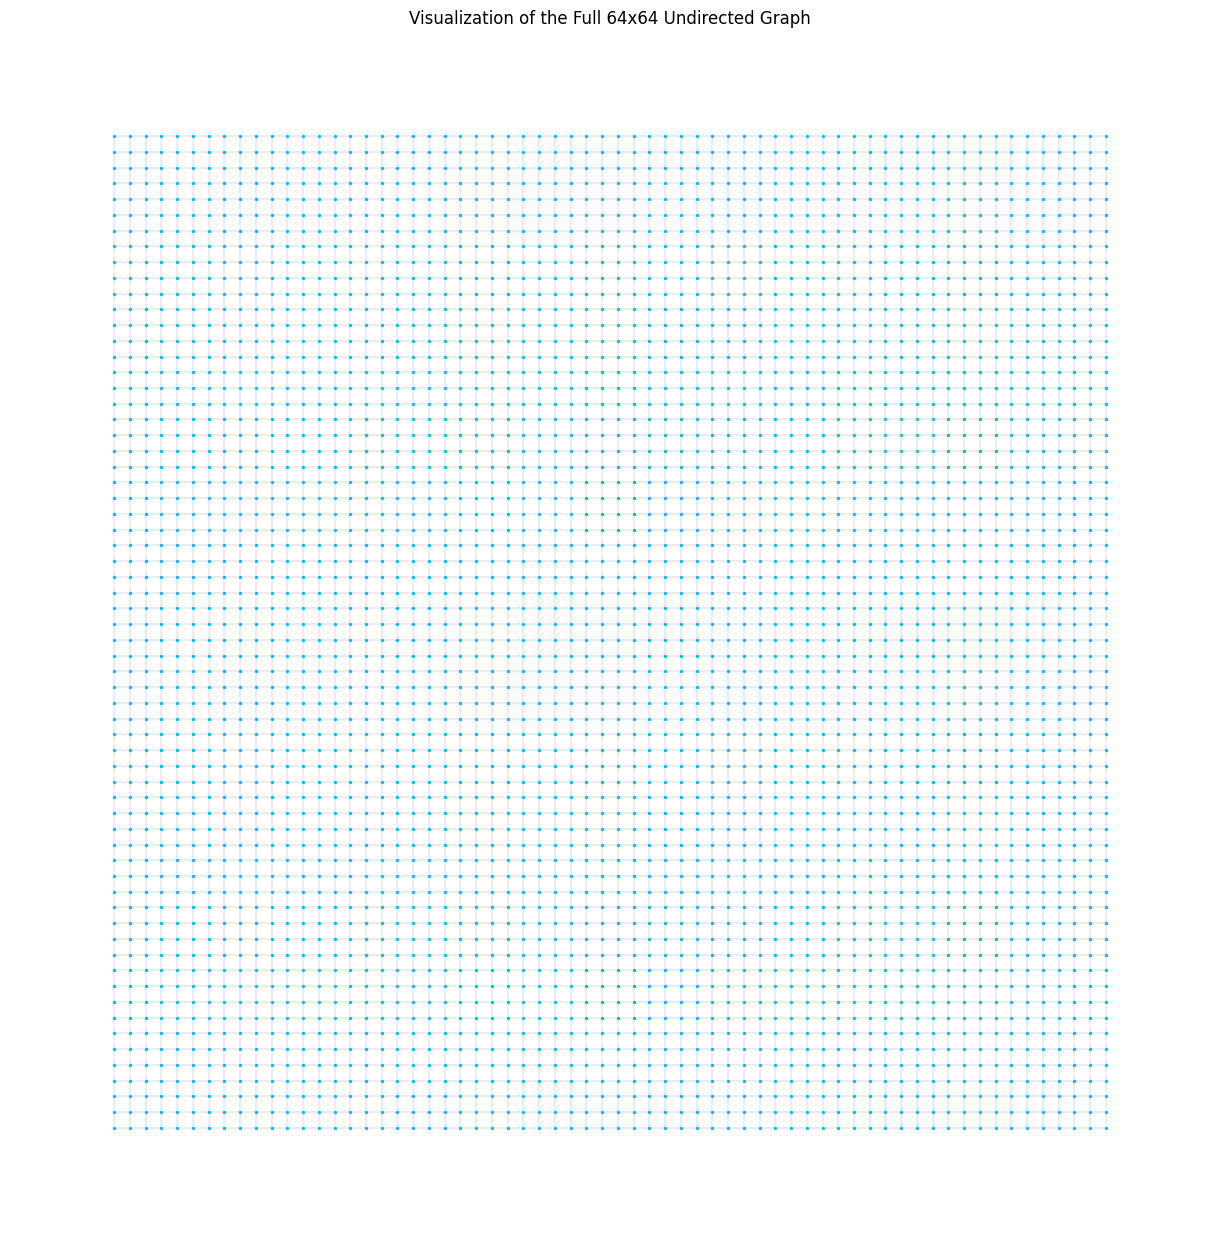

In [13]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from pathlib import Path

def visualize_full_pyg_graph(dataset_path):
    """
    Loads a PyG dataset and visualizes the complete, UNDIRECTED structure 
    of the first graph.
    """
    if not dataset_path.exists():
        print(f"❌ Error: Dataset file not found at '{dataset_path}'")
        return

    # 1. Load the dataset
    print(f"Loading dataset from '{dataset_path}'...")
    pyg_dataset = torch.load(dataset_path, weights_only=False)
    data = pyg_dataset[0] 
    print("Dataset loaded successfully.")

    # 2. Convert the PyG Data object to a NetworkX graph
    print("Converting the full graph to NetworkX format...")
    G = to_networkx(data, node_attrs=['pos'])
    
    # --- THIS IS THE NEW LINE ---
    # Create an undirected version of the graph for plotting
    G = G.to_undirected()
    # --------------------------
    
    # 3. Get the node positions for a grid layout
    pos = nx.get_node_attributes(G, 'pos')

    print("Plotting the full undirected graph... (This may take a moment)")
    plt.figure(figsize=(12, 12))
    
    nx.draw(G, pos, 
            with_labels=False,
            node_size=2,
            width=0.1,
            node_color='deepskyblue')
    
    plt.title("Visualization of the Full 64x64 Undirected Graph")
    plt.show()

# --- Main execution ---
visualize_full_pyg_graph(dataset_file)

Loading dataset from '/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases_processed/normalized_datasets/train_cases_normalized/p_L_125000_rho_L_0.875_train_with_pos_normalized.pt'...
✅ Successfully loaded 30 graphs.

📊 Generating degree histograms for timesteps: [0, 15, 29]...


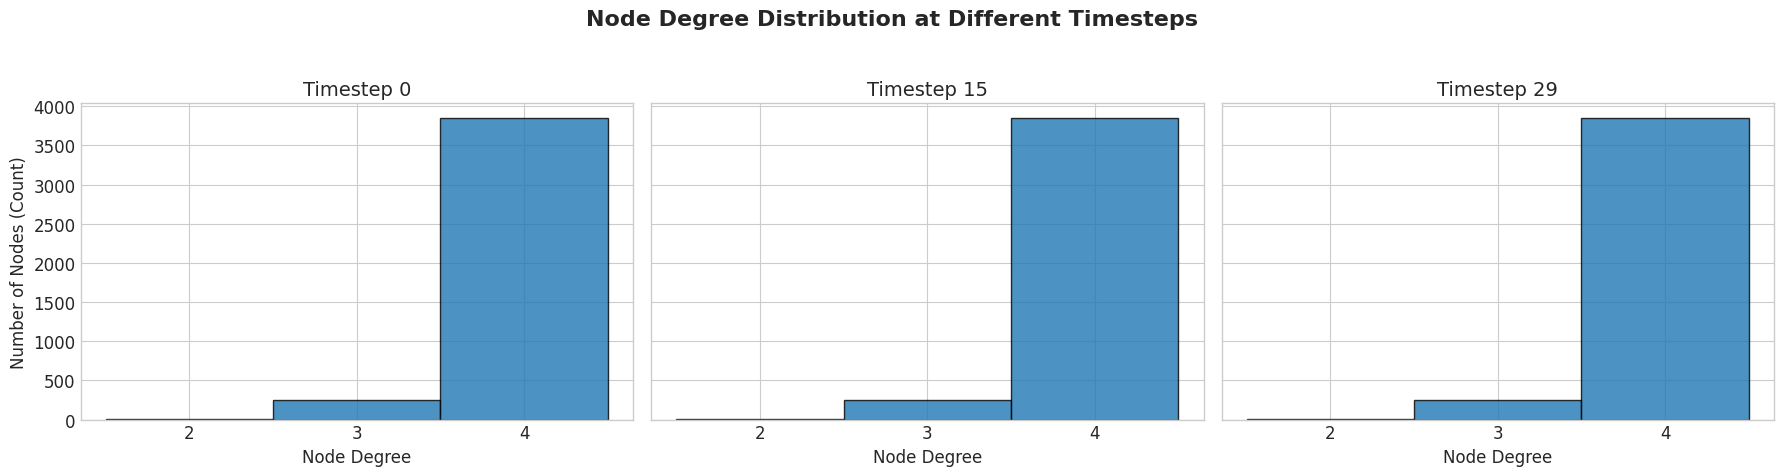

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import warnings

# --- PyTorch Geometric Imports ---
import torch_geometric.data
from torch_geometric.utils import degree
import torch.serialization

# Add the specific PyG class to the safe list to resolve the loading error
torch.serialization.add_safe_globals([
    torch_geometric.data.data.Data,
    torch_geometric.data.data.DataEdgeAttr
])

# Suppress UserWarnings from PyTorch Geometric
warnings.filterwarnings("ignore", category=UserWarning)

# ==============================================================================
# ⚙️ 1. Configuration
# ==============================================================================
# Set the path to your PyTorch Geometric dataset file
# Make sure this is the correct path for your shock_tube.pt file
DATASET_PATH = Path('/standard/sds_baek_energetic/PSAAP - SAGEST/Chord_ShockTube_0.5x0.5mDomain_64x64Cells/cases_processed/normalized_datasets/train_cases_normalized/p_L_125000_rho_L_0.875_train_with_pos_normalized.pt') 

# --- Plotting Style ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'figure.titlesize': 16,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# ==============================================================================
# 🛠️ 2. New Analysis Function: Degree Histogram
# ==============================================================================

def plot_degree_histograms(all_graphs: list, timesteps_to_plot: list):
    """
    Calculates and plots the node degree distribution as a histogram for
    a few specified timesteps.
    """
    print(f"\n📊 Generating degree histograms for timesteps: {timesteps_to_plot}...")

    if not all_graphs:
        print("⚠️ List of graphs is empty. Nothing to analyze.")
        return

    # Create subplots - one for each timestep
    num_plots = len(timesteps_to_plot)
    fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5), sharey=True)
    fig.suptitle('Node Degree Distribution at Different Timesteps', fontsize=16, fontweight='bold')

    for i, timestep_idx in enumerate(timesteps_to_plot):
        if timestep_idx >= len(all_graphs):
            print(f"⚠️ Warning: Timestep {timestep_idx} is out of bounds. Skipping.")
            continue

        ax = axes[i]
        graph_data = all_graphs[timestep_idx]

        if graph_data.num_edges == 0:
            ax.set_title(f"Timestep {timestep_idx}\n(No Edges)")
            ax.set_xlabel("Node Degree")
            if i == 0:
                ax.set_ylabel("Number of Nodes")
            continue

        # Use the same robust degree calculation from before
        effective_num_nodes = max(graph_data.num_nodes, graph_data.edge_index.max().item() + 1)
        d = degree(graph_data.edge_index[0], num_nodes=effective_num_nodes)
        
        # Convert to numpy for plotting
        degrees_np = d.cpu().numpy()

        # Plot the histogram
        # Using a specific number of bins can help, especially for integer data.
        # Let's define bins to be centered on integer degrees.
        bins = np.arange(degrees_np.min(), degrees_np.max() + 2) - 0.5
        ax.hist(degrees_np, bins=bins, edgecolor='black', alpha=0.8)
        
        ax.set_title(f"Timestep {timestep_idx}")
        ax.set_xlabel("Node Degree")
        
        # Set major ticks to be integers
        ax.locator_params(axis='x', integer=True)

    axes[0].set_ylabel("Number of Nodes (Count)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

# ==============================================================================
# 🚀 3. Main Execution
# ==============================================================================

def main():
    """Main function to load data and run the analysis."""
    if not DATASET_PATH.exists():
        print(f"❌ Error: Dataset file not found at '{DATASET_PATH}'")
        return

    print(f"Loading dataset from '{DATASET_PATH}'...")
    try:
        with torch.serialization.safe_globals([torch_geometric.data.data.Data, torch_geometric.data.data.DataEdgeAttr]):
             all_graphs = torch.load(DATASET_PATH, weights_only=False)
        
        if not isinstance(all_graphs, list) or not all_graphs:
             print("⚠️ Loaded data is not a valid list of graphs. Please check the file.")
             return
             
        print(f"✅ Successfully loaded {len(all_graphs)} graphs.")
        
    except Exception as e:
        print(f"An error occurred while loading the file: {e}")
        return

    # --- Define which timesteps to plot ---
    # We'll pick the first, middle, and last timesteps for comparison.
    num_graphs = len(all_graphs)
    timesteps_to_plot = [0, num_graphs // 2, num_graphs - 1]
    
    # --- Run the histogram analysis ---
    plot_degree_histograms(all_graphs, timesteps_to_plot)


# This ensures the script runs when executed
if __name__ == '__main__':
    main()

# Data Processing

# River